In [1]:
import sys, os 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import random
import numpy as np 


In [3]:
import qiskit

In [4]:
from qiskit import QuantumCircuit
from IBMQuantumExperience import IBMQuantumExperience
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ

provider = IBMQ.enable_account('30814b96578f61cf09348976d843ad494d71335183c0c5cca90c03977b9eb2ec5f781f367dafbdb81e32a3624c556cac6c1ca2b7675b94fd61609d6a2b8385bc')


In [5]:
print(provider)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>


In [6]:

class Alice:
    def prepareState(self, n, delta):
        
        nQubits = int((4 + delta)*n) # number of physical qubits
        
        a = np.random.randint(2, size=(nQubits,))      # random data bits
        b = np.random.randint(2, size=(nQubits,))
        
        print("Alice has generated random secret data bits, a: ", a)
        print("She will arbitrarily encode these bits using random basis, b: ", b)
        return (a, b)
    
class Bob:
    def generateRandomBasis(self, n, delta):
        nQubits = int((4 + delta)*n) # number of physical qubits
        b = np.random.randint(2, size=(nQubits,))
        
        print("Bob has chosen random basis, b': ", b)
        return b
        
class Eve:
    def generateRandomBasis(self, n, delta):
        nQubits = int((4 + delta)*n) # number of physical qubits
        b = np.random.randint(2, size=(nQubits,))
        
        print("Eve has chosen random basis: ", b)
        return b
    

In [7]:
from qiskit import circuit
from qiskit import QuantumCircuit
def BB84Program(key_length):
    qp = QuantumCircuit()
    
    # key length
    n = key_length
    # error slack
    delta = 0
    # number of physical qubits
    nQubits = int((4 + delta)*n)

    
    # Creating registers
    # qubits for querying the oracle and finding the hidden integer
    qr_1 = circuit.QuantumRegister(name="qr_1",size= nQubits)
    # for recording the measurement on qr
    cr_1 = circuit.ClassicalRegister(name="cr_1",size= nQubits)
    
    # qubits for querying the oracle and finding the hidden integer
    qr_2 = circuit.QuantumRegister(name="qr_2",size= nQubits)
    # for recording the measurement on qr
    cr_2 = circuit.ClassicalRegister(name="cr_2",size= nQubits)
    
    circuitName = "BB84"
    circuitName_eve = "BB84-Eve"
    bbCircuit = QuantumCircuit( qr_1, cr_1, name=circuitName)
    bb_eve_Circuit = QuantumCircuit( qr_2, cr_2, name=circuitName_eve )
    
    # Initialize Alice and Bob ... and Eve! 
    alice = Alice()
    bob = Bob()
    eve = Eve()
    
    # Have Alice generate secrets a, b with chosen n and delta
    (a, b) = alice.prepareState(n, delta)
    
    # Apply Hadamard gates before querying the oracle
    for i in range(nQubits):
        if a[i] == 1:
            # X gates will send |0> -> |1> 
            bbCircuit.x(qr_1[i])
            bb_eve_Circuit.x(qr_2[i])
    
    for i in range(nQubits):
        if b[i] == 1:
            # encode in X basis
            bbCircuit.h(qr_1[i])
            bb_eve_Circuit.h(qr_2[i])
    
    # Bob generates his random basis string, b'
    b_prime = bob.generateRandomBasis(n, delta)
    
    # Eve also takes a stab at guessing the basis
    b_eve = eve.generateRandomBasis(n, delta)
    
    # Eve makes some measurements !
    for i in range(nQubits):
        if b_eve[i] == 1:
            # measure in X basis (otherwise Eve measures in Z)
            bb_eve_Circuit.h(qr_2[i])
    
    # Bob measures the qubits based off of b'
    
    for i in range(nQubits):
        if b_prime[i] == 1:
            # measure in X basis (as opposed to Z)
            bbCircuit.h(qr_1[i])
            bb_eve_Circuit.h(qr_2[i])
        
    for i in range(nQubits):
        bbCircuit.measure(qr_1[i], cr_1[i])
        bb_eve_Circuit.measure(qr_2[i], cr_2[i])
        
    return (qp, a, b, b_prime, bbCircuit, bb_eve_Circuit, circuitName, circuitName_eve)

In [8]:

def determineKey(a, bob_meas, b, b_prime, n):
    # Now, it is safe for Alice to announce b to Bob. They can then determine in which places their b and b' agree.
    # Let's call the indices where b_i = b'_i, array x
    x = [b_i == b_prime_i for (b_i, b_prime_i) in zip(b, b_prime)]
    
    # The size of x should be 1/2 nQubits, in expectation
    if np.sum(x) < n / 2:
        print("Aborting protocol. Less than 2n bits match between b and b'")
        return False
    else:
        # We can then use this to discard the key bits accordingly (on each side)
    
        # Alice's original secret key, a, subsetted where b and b' agree
        alice_bits = a[x]
        # Bob's measurement in his random basis b', subsetted where b and b' agree
        bob_bits = bob_meas[x]
    
        # Now, we can use half of these bits as "check bits" to see if there was any interference (announcing publicly)
        # Let's just take the first n bits as check bits, WLOG
        
        check_alice = alice_bits[:n]
        key_alice = alice_bits[-n:]
        check_bob = bob_bits[:n]
        key_bob = bob_bits[-n:]
        
        print("Alice has check bits: ", check_alice)
        print("Bob has check bits: ", check_bob)
        
        # Now, they publicly determine the error in their check bits
        mismatch = [k_a != k_b for (k_a, k_b) in zip(key_alice, key_bob)]
        error = (np.sum(mismatch)) / n
        
        # Let's choose epsilon = 0.05 as our error threshold
        epsilon = 0.05
        if error > epsilon:
            print("Interference detected... Aborting!")
            return False
        else:
            print("Successfully exchanged private key: ", key_alice)
            return True

In [10]:
from qiskit import execute
from qiskit import BasicAer
from qiskit import result
def testCircuits(shots, key_length):

    # use local qasm simulator
    #backend = 'qasm_simulator'
    backend = BasicAer.get_backend('qasm_simulator')
    qp, a, b, b_prime, bbcircuit, bb_eve_Circuit, circuitName, circuitName_eve = BB84Program(key_length)
    
    
    print("Simulating...")
    print(circuitName)
    print(bbcircuit)
    results = execute(experiments=bbcircuit, backend = backend, shots=shots).result()
    answer = results.get_counts(bbcircuit)
    print(circuitName_eve)
    print(bb_eve_Circuit)
    results_eve = execute(experiments=bb_eve_Circuit, backend = backend,  shots=shots).result()
    answer_eve = results_eve.get_counts(bb_eve_Circuit)
    
    return (answer, answer_eve, a, b, b_prime)

(answer, answer_eve, a, b, b_prime) = testCircuits(2**10, 4)
print("Discrete distribution of potential measurements by Bob: \n ", answer)
print("\n")
print("\n")
print("\n")
print("\n")
print("Discrete distribution of potential measurements by Bob with eavesdropping: \n", answer_eve)

Alice has generated random secret data bits, a:  [1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0]
Bob has chosen random basis, b':  [0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1]
Eve has chosen random basis:  [0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1]
Simulating...
BB84
         ┌───┐┌───┐                          ┌─┐                           
 qr_1_0: ┤ X ├┤ H ├──────────────────────────┤M├───────────────────────────
         └───┘└┬─┬┘                          └╥┘                           
 qr_1_1: ──────┤M├────────────────────────────╫────────────────────────────
         ┌───┐ └╥┘ ┌───┐                      ║ ┌─┐                        
 qr_1_2: ┤ H ├──╫──┤ H ├──────────────────────╫─┤M├────────────────────────
         ├───┤  ║  ├───┤                      ║ └╥┘┌─┐                     
 qr_1_3: ┤ X ├──╫──┤ H ├──────────────────────╫──╫─┤M├─────────────────────
         └───┘  ║  └┬─┬┘                      ║  ║ └╥┘       

In [11]:

def getMeasurement(answer, answer_eve):
    bob_meas = list(random.choice(list(answer.keys())))
    bob_meas = list(map(int, bob_meas))
    bob_meas = np.array(bob_meas)
    bob_meas = bob_meas[::-1]
    print("Bob's measurement result: ", bob_meas)
    
    bob_meas_eve = list(random.choice(list(answer_eve.keys())))
    bob_meas_eve = list(map(int, bob_meas_eve))
    bob_meas_eve = np.array(bob_meas_eve)
    bob_meas_eve = bob_meas_eve[::-1]
    print("Bob's measurement result with eavesdropping: ", bob_meas_eve)
    
    return (bob_meas, bob_meas_eve)
    
bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)

Bob's measurement result:  [0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1]
Bob's measurement result with eavesdropping:  [0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1]


In [12]:
print("Key Exchange without eavesdropping: ")
res = determineKey(a, bob_meas, b, b_prime, 4)
print("Key Exchange with eavesdropping: ")
res = determineKey(a, bob_meas_eve, b, b_prime, 4)

Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 0]
Bob has check bits:  [0 0 0 0]
Successfully exchanged private key:  [0 1 0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 0 0]
Bob has check bits:  [0 1 0 0]
Successfully exchanged private key:  [0 1 0 0]


In [13]:
def plot_eve_undetected(probs):
    
    objects = ('2', '4', '8')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, probs, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    
    plt.xlabel("Key Length")
    plt.ylabel('Probability')
    plt.title('Probability of Undetected Eavesdropping')
    
    plt.show()

In [19]:

probs = []

for n in [2, 4, 8, 10]:
    succ = 0
    succ_eve = 0
    for i in range(2**7):
        print("Simulation round:", i)
        # Simulate one measurement with key length n = 4
        (answer, answer_eve, a, b, b_prime) = testCircuits(1, n)
        bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)
        print("Key Exchange without eavesdropping: ")
        res = determineKey(a, bob_meas, b, b_prime,n)
        # successful
        if res: 
            succ += 1
        print("Key Exchange with eavesdropping: ")
        res = determineKey(a, bob_meas_eve, b, b_prime,n)
        # successful
        if res: 
            succ_eve += 1
        
    print("n=", n)
    print("Successful key exchanges without Eve present: ", succ)
    print("Successful key exchanges with Eve present: ", succ_eve)
    p = (succ_eve) / (2**7)
    probs.append(p)
    
plot_eve()

Simulation round: 0
Alice has generated random secret data bits, a:  [0 0 1 0 1 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 1 0 1 0 1 0 0]
Bob has chosen random basis, b':  [0 1 0 1 1 0 1 0]
Eve has chosen random basis:  [1 0 1 1 1 1 0 1]
Simulating...
BB84
        ┌───┐     ┌─┐                  
qr_1_0: ┤ H ├─────┤M├──────────────────
        ├───┤┌───┐└╥┘   ┌─┐            
qr_1_1: ┤ H ├┤ H ├─╫────┤M├────────────
        ├───┤└───┘ ║ ┌─┐└╥┘            
qr_1_2: ┤ X ├──────╫─┤M├─╫─────────────
        ├───┤┌───┐ ║ └╥┘ ║ ┌─┐         
qr_1_3: ┤ H ├┤ H ├─╫──╫──╫─┤M├─────────
        ├───┤├───┤ ║  ║  ║ └╥┘┌─┐      
qr_1_4: ┤ X ├┤ H ├─╫──╫──╫──╫─┤M├──────
        ├───┤├───┤ ║  ║  ║  ║ └╥┘┌─┐   
qr_1_5: ┤ X ├┤ H ├─╫──╫──╫──╫──╫─┤M├───
        ├───┤├───┤ ║  ║  ║  ║  ║ └╥┘┌─┐
qr_1_6: ┤ X ├┤ H ├─╫──╫──╫──╫──╫──╫─┤M├
        └┬─┬┘└───┘ ║  ║  ║  ║  ║  ║ └╥┘
qr_1_7: ─┤M├───────╫──╫──╫──╫──╫──╫──╫─
         └╥┘       ║  ║  ║  ║  ║  ║  ║ 
cr_1: 8/══╩════════╩══╩══╩══╩══╩═

        ┌───┐┌───┐┌───┐              ┌─┐      
qr_2_0: ┤ X ├┤ H ├┤ H ├──────────────┤M├──────
        ├───┤└───┘└───┘┌─┐           └╥┘      
qr_2_1: ┤ H ├──────────┤M├────────────╫───────
        ├───┤┌───┐┌───┐└╥┘┌───┐       ║    ┌─┐
qr_2_2: ┤ X ├┤ H ├┤ H ├─╫─┤ H ├───────╫────┤M├
        └───┘└┬─┬┘└───┘ ║ └───┘       ║    └╥┘
qr_2_3: ──────┤M├───────╫─────────────╫─────╫─
        ┌───┐ └╥┘ ┌───┐ ║      ┌─┐    ║     ║ 
qr_2_4: ┤ X ├──╫──┤ H ├─╫──────┤M├────╫─────╫─
        ├───┤  ║  ├───┤ ║      └╥┘┌─┐ ║     ║ 
qr_2_5: ┤ H ├──╫──┤ H ├─╫───────╫─┤M├─╫─────╫─
        ├───┤  ║  ├───┤ ║ ┌───┐ ║ └╥┘ ║ ┌─┐ ║ 
qr_2_6: ┤ X ├──╫──┤ H ├─╫─┤ H ├─╫──╫──╫─┤M├─╫─
        ├───┤  ║  └┬─┬┘ ║ └───┘ ║  ║  ║ └╥┘ ║ 
qr_2_7: ┤ H ├──╫───┤M├──╫───────╫──╫──╫──╫──╫─
        └───┘  ║   └╥┘  ║       ║  ║  ║  ║  ║ 
cr_2: 8/═══════╩════╩═══╩═══════╩══╩══╩══╩══╩═
               3    7   1       4  5  0  6  2 
Bob's measurement result:  [1 1 1 0 1 0 1 0]
Bob's measurement result with eavesdropping:  [1 0 0 0 1 0 1 0

BB84-Eve
             ┌─┐                                
qr_2_0: ─────┤M├────────────────────────────────
        ┌───┐└╥┘┌───┐┌───┐             ┌─┐      
qr_2_1: ┤ X ├─╫─┤ H ├┤ H ├─────────────┤M├──────
        ├───┤ ║ ├───┤├───┤             └╥┘┌─┐   
qr_2_2: ┤ H ├─╫─┤ H ├┤ H ├──────────────╫─┤M├───
        └───┘ ║ └┬─┬┘└───┘              ║ └╥┘   
qr_2_3: ──────╫──┤M├────────────────────╫──╫────
        ┌───┐ ║  └╥┘ ┌───┐     ┌─┐      ║  ║    
qr_2_4: ┤ H ├─╫───╫──┤ H ├─────┤M├──────╫──╫────
        ├───┤ ║   ║  ├───┤┌───┐└╥┘┌───┐ ║  ║ ┌─┐
qr_2_5: ┤ X ├─╫───╫──┤ H ├┤ H ├─╫─┤ H ├─╫──╫─┤M├
        ├───┤ ║   ║  ├───┤└┬─┬┘ ║ └───┘ ║  ║ └╥┘
qr_2_6: ┤ H ├─╫───╫──┤ H ├─┤M├──╫───────╫──╫──╫─
        └┬─┬┘ ║   ║  └───┘ └╥┘  ║       ║  ║  ║ 
qr_2_7: ─┤M├──╫───╫─────────╫───╫───────╫──╫──╫─
         └╥┘  ║   ║         ║   ║       ║  ║  ║ 
cr_2: 8/══╩═══╩═══╩═════════╩═══╩═══════╩══╩══╩═
          7   0   3         6   4       1  2  5 
Bob's measurement result:  [0 1 0 0 0 1 1 0]
Bob's measureme

Simulation round: 24
Alice has generated random secret data bits, a:  [1 1 1 0 1 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 0 0 0 0 0]
Bob has chosen random basis, b':  [1 1 1 0 0 1 0 1]
Eve has chosen random basis:  [0 0 0 1 0 0 1 0]
Simulating...
BB84
        ┌───┐┌───┐           ┌─┐         
qr_1_0: ┤ X ├┤ H ├───────────┤M├─────────
        ├───┤├───┤           └╥┘┌─┐      
qr_1_1: ┤ X ├┤ H ├────────────╫─┤M├──────
        ├───┤├───┤            ║ └╥┘┌─┐   
qr_1_2: ┤ X ├┤ H ├────────────╫──╫─┤M├───
        └───┘└┬─┬┘            ║  ║ └╥┘   
qr_1_3: ──────┤M├─────────────╫──╫──╫────
        ┌───┐ └╥┘      ┌─┐    ║  ║  ║    
qr_1_4: ┤ X ├──╫───────┤M├────╫──╫──╫────
        ├───┤  ║  ┌───┐└╥┘    ║  ║  ║ ┌─┐
qr_1_5: ┤ X ├──╫──┤ H ├─╫─────╫──╫──╫─┤M├
        ├───┤  ║  └┬─┬┘ ║     ║  ║  ║ └╥┘
qr_1_6: ┤ X ├──╫───┤M├──╫─────╫──╫──╫──╫─
        ├───┤  ║   └╥┘  ║ ┌─┐ ║  ║  ║  ║ 
qr_1_7: ┤ H ├──╫────╫───╫─┤M├─╫──╫──╫──╫─
        └───┘  ║    ║   ║ └╥┘ ║  ║  ║  ║

Bob's measurement result with eavesdropping:  [1 0 0 1 1 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [1 0]
Interference detected... Aborting!
Simulation round: 32
Alice has generated random secret data bits, a:  [0 1 0 0 0 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 1 1 0 1 0 0 0]
Bob has chosen random basis, b':  [1 1 1 0 0 1 0 1]
Eve has chosen random basis:  [1 1 0 0 0 0 0 0]
Simulating...
BB84
        ┌───┐┌───┐              ┌─┐      
qr_1_0: ┤ H ├┤ H ├──────────────┤M├──────
        ├───┤├───┤┌───┐         └╥┘   ┌─┐
qr_1_1: ┤ X ├┤ H ├┤ H ├──────────╫────┤M├
        ├───┤├───┤└───┘          ║ ┌─┐└╥┘
qr_1_2: ┤ H ├┤ H ├───────────────╫─┤M├─╫─
        └───┘└┬─┬┘               ║ └╥┘ ║ 
qr_1_3: ──────┤M├────────────────╫──╫──╫─
        ┌───┐ └╥┘  ┌─┐           ║  ║  ║ 
qr_1_4: ┤

        ┌───┐     ┌─┐                  
qr_1_0: ┤ X ├─────┤M├──────────────────
        ├───┤┌───┐└╥┘            ┌─┐   
qr_1_1: ┤ H ├┤ H ├─╫─────────────┤M├───
        ├───┤├───┤ ║             └╥┘┌─┐
qr_1_2: ┤ H ├┤ H ├─╫──────────────╫─┤M├
        ├───┤└───┘ ║ ┌─┐          ║ └╥┘
qr_1_3: ┤ H ├──────╫─┤M├──────────╫──╫─
        ├───┤      ║ └╥┘┌─┐       ║  ║ 
qr_1_4: ┤ H ├──────╫──╫─┤M├───────╫──╫─
        └───┘ ┌─┐  ║  ║ └╥┘       ║  ║ 
qr_1_5: ──────┤M├──╫──╫──╫────────╫──╫─
        ┌───┐ └╥┘  ║  ║  ║ ┌─┐    ║  ║ 
qr_1_6: ┤ H ├──╫───╫──╫──╫─┤M├────╫──╫─
        ├───┤  ║   ║  ║  ║ └╥┘┌─┐ ║  ║ 
qr_1_7: ┤ X ├──╫───╫──╫──╫──╫─┤M├─╫──╫─
        └───┘  ║   ║  ║  ║  ║ └╥┘ ║  ║ 
cr_1: 8/═══════╩═══╩══╩══╩══╩══╩══╩══╩═
               5   0  3  4  6  7  1  2 
BB84-Eve
        ┌───┐┌───┐           ┌─┐            
qr_2_0: ┤ X ├┤ H ├───────────┤M├────────────
        ├───┤├───┤           └╥┘┌─┐         
qr_2_1: ┤ H ├┤ H ├────────────╫─┤M├─────────
        ├───┤├───┤┌───┐       ║ └╥┘      ┌─┐
qr_2_2

Bob has chosen random basis, b':  [1 1 1 0 0 1 1 0]
Eve has chosen random basis:  [1 0 1 1 0 0 1 0]
Simulating...
BB84
        ┌───┐┌───┐     ┌─┐                  
qr_1_0: ┤ H ├┤ H ├─────┤M├──────────────────
        ├───┤├───┤┌───┐└╥┘               ┌─┐
qr_1_1: ┤ X ├┤ H ├┤ H ├─╫────────────────┤M├
        ├───┤├───┤└───┘ ║ ┌─┐            └╥┘
qr_1_2: ┤ X ├┤ H ├──────╫─┤M├─────────────╫─
        └───┘└┬─┬┘      ║ └╥┘             ║ 
qr_1_3: ──────┤M├───────╫──╫──────────────╫─
        ┌───┐ └╥┘ ┌───┐ ║  ║ ┌─┐          ║ 
qr_1_4: ┤ X ├──╫──┤ H ├─╫──╫─┤M├──────────╫─
        ├───┤  ║  ├───┤ ║  ║ └╥┘┌─┐       ║ 
qr_1_5: ┤ H ├──╫──┤ H ├─╫──╫──╫─┤M├───────╫─
        ├───┤  ║  ├───┤ ║  ║  ║ └╥┘┌─┐    ║ 
qr_1_6: ┤ X ├──╫──┤ H ├─╫──╫──╫──╫─┤M├────╫─
        ├───┤  ║  ├───┤ ║  ║  ║  ║ └╥┘┌─┐ ║ 
qr_1_7: ┤ X ├──╫──┤ H ├─╫──╫──╫──╫──╫─┤M├─╫─
        └───┘  ║  └───┘ ║  ║  ║  ║  ║ └╥┘ ║ 
cr_1: 8/═══════╩════════╩══╩══╩══╩══╩══╩══╩═
               3        0  2  4  5  6  7  1 
BB84-Eve
        ┌───┐┌───

             ┌─┐                              
qr_1_0: ─────┤M├──────────────────────────────
             └╥┘┌─┐                           
qr_1_1: ──────╫─┤M├───────────────────────────
        ┌───┐ ║ └╥┘┌───┐┌───┐           ┌─┐   
qr_1_2: ┤ X ├─╫──╫─┤ H ├┤ H ├───────────┤M├───
        ├───┤ ║  ║ ├───┤└───┘     ┌─┐   └╥┘   
qr_1_3: ┤ H ├─╫──╫─┤ H ├──────────┤M├────╫────
        ├───┤ ║  ║ ├───┤          └╥┘┌─┐ ║    
qr_1_4: ┤ X ├─╫──╫─┤ H ├───────────╫─┤M├─╫────
        ├───┤ ║  ║ └───┘ ┌─┐       ║ └╥┘ ║    
qr_1_5: ┤ X ├─╫──╫───────┤M├───────╫──╫──╫────
        ├───┤ ║  ║ ┌───┐ └╥┘ ┌───┐ ║  ║  ║ ┌─┐
qr_1_6: ┤ X ├─╫──╫─┤ H ├──╫──┤ H ├─╫──╫──╫─┤M├
        ├───┤ ║  ║ └┬─┬┘  ║  └───┘ ║  ║  ║ └╥┘
qr_1_7: ┤ H ├─╫──╫──┤M├───╫────────╫──╫──╫──╫─
        └───┘ ║  ║  └╥┘   ║        ║  ║  ║  ║ 
cr_1: 8/══════╩══╩═══╩════╩════════╩══╩══╩══╩═
              0  1   7    5        3  4  2  6 
BB84-Eve
        ┌───┐     ┌─┐                              
qr_2_0: ┤ H ├─────┤M├─────────────────────────

Alice has generated random secret data bits, a:  [1 0 1 0 0 0 0 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 0 0 1 1 1 0]
Bob has chosen random basis, b':  [0 1 0 0 0 0 1 1]
Eve has chosen random basis:  [0 1 0 1 0 0 0 1]
Simulating...
BB84
        ┌───┐┌───┐                 ┌─┐   
qr_1_0: ┤ X ├┤ H ├─────────────────┤M├───
        ├───┤└───┘     ┌─┐         └╥┘   
qr_1_1: ┤ H ├──────────┤M├──────────╫────
        ├───┤          └╥┘┌─┐       ║    
qr_1_2: ┤ X ├───────────╫─┤M├───────╫────
        └───┘ ┌─┐       ║ └╥┘       ║    
qr_1_3: ──────┤M├───────╫──╫────────╫────
        ┌───┐ └╥┘       ║  ║ ┌─┐    ║    
qr_1_4: ┤ H ├──╫────────╫──╫─┤M├────╫────
        ├───┤  ║        ║  ║ └╥┘┌─┐ ║    
qr_1_5: ┤ H ├──╫────────╫──╫──╫─┤M├─╫────
        ├───┤  ║  ┌───┐ ║  ║  ║ └╥┘ ║ ┌─┐
qr_1_6: ┤ H ├──╫──┤ H ├─╫──╫──╫──╫──╫─┤M├
        ├───┤  ║  └┬─┬┘ ║  ║  ║  ║  ║ └╥┘
qr_1_7: ┤ H ├──╫───┤M├──╫──╫──╫──╫──╫──╫─
        └───┘  ║   └╥┘  ║  ║  ║  ║  ║  ║ 
cr_1: 8/═══════╩═══

        ┌───┐     ┌─┐                    
qr_2_0: ┤ H ├─────┤M├────────────────────
        ├───┤┌───┐└╥┘     ┌─┐            
qr_2_1: ┤ X ├┤ H ├─╫──────┤M├────────────
        ├───┤├───┤ ║      └╥┘┌─┐         
qr_2_2: ┤ X ├┤ H ├─╫───────╫─┤M├─────────
        ├───┤├───┤ ║       ║ └╥┘┌─┐      
qr_2_3: ┤ H ├┤ H ├─╫───────╫──╫─┤M├──────
        ├───┤├───┤ ║       ║  ║ └╥┘┌─┐   
qr_2_4: ┤ X ├┤ H ├─╫───────╫──╫──╫─┤M├───
        ├───┤├───┤ ║ ┌───┐ ║  ║  ║ └╥┘┌─┐
qr_2_5: ┤ H ├┤ H ├─╫─┤ H ├─╫──╫──╫──╫─┤M├
        ├───┤└┬─┬┘ ║ └───┘ ║  ║  ║  ║ └╥┘
qr_2_6: ┤ H ├─┤M├──╫───────╫──╫──╫──╫──╫─
        ├───┤ └╥┘  ║  ┌─┐  ║  ║  ║  ║  ║ 
qr_2_7: ┤ H ├──╫───╫──┤M├──╫──╫──╫──╫──╫─
        └───┘  ║   ║  └╥┘  ║  ║  ║  ║  ║ 
cr_2: 8/═══════╩═══╩═══╩═══╩══╩══╩══╩══╩═
               6   0   7   1  2  3  4  5 
Bob's measurement result:  [0 1 1 0 1 0 1 0]
Bob's measurement result with eavesdropping:  [1 0 1 0 0 1 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 0]


        ┌───┐     ┌─┐                           
qr_2_0: ┤ X ├─────┤M├───────────────────────────
        ├───┤┌───┐└╥┘┌───┐                ┌─┐   
qr_2_1: ┤ H ├┤ H ├─╫─┤ H ├────────────────┤M├───
        ├───┤├───┤ ║ └───┘     ┌─┐        └╥┘   
qr_2_2: ┤ H ├┤ H ├─╫───────────┤M├─────────╫────
        ├───┤├───┤ ║           └╥┘┌─┐      ║    
qr_2_3: ┤ X ├┤ H ├─╫────────────╫─┤M├──────╫────
        ├───┤└───┘ ║  ┌─┐       ║ └╥┘      ║    
qr_2_4: ┤ H ├──────╫──┤M├───────╫──╫───────╫────
        ├───┤┌───┐ ║  └╥┘ ┌───┐ ║  ║ ┌───┐ ║ ┌─┐
qr_2_5: ┤ X ├┤ H ├─╫───╫──┤ H ├─╫──╫─┤ H ├─╫─┤M├
        ├───┤├───┤ ║   ║  └┬─┬┘ ║  ║ └───┘ ║ └╥┘
qr_2_6: ┤ X ├┤ H ├─╫───╫───┤M├──╫──╫───────╫──╫─
        ├───┤├───┤ ║   ║   └╥┘  ║  ║  ┌─┐  ║  ║ 
qr_2_7: ┤ H ├┤ H ├─╫───╫────╫───╫──╫──┤M├──╫──╫─
        └───┘└───┘ ║   ║    ║   ║  ║  └╥┘  ║  ║ 
cr_2: 8/═══════════╩═══╩════╩═══╩══╩═══╩═══╩══╩═
                   0   4    6   2  3   7   1  5 
Bob's measurement result:  [1 0 0 1 1 1 1 0]
Bob's measurement result

Alice has generated random secret data bits, a:  [0 1 0 0 1 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 1 0 0 1 1 0 1]
Bob has chosen random basis, b':  [0 0 0 1 0 1 0 1]
Eve has chosen random basis:  [0 1 0 0 0 0 1 0]
Simulating...
BB84
        ┌───┐          ┌─┐                  
qr_1_0: ┤ H ├──────────┤M├──────────────────
        ├───┤┌───┐     └╥┘      ┌─┐         
qr_1_1: ┤ X ├┤ H ├──────╫───────┤M├─────────
        └───┘└┬─┬┘      ║       └╥┘         
qr_1_2: ──────┤M├───────╫────────╫──────────
        ┌───┐ └╥┘       ║ ┌─┐    ║          
qr_1_3: ┤ H ├──╫────────╫─┤M├────╫──────────
        ├───┤  ║  ┌───┐ ║ └╥┘    ║ ┌─┐      
qr_1_4: ┤ X ├──╫──┤ H ├─╫──╫─────╫─┤M├──────
        ├───┤  ║  ├───┤ ║  ║     ║ └╥┘┌─┐   
qr_1_5: ┤ H ├──╫──┤ H ├─╫──╫─────╫──╫─┤M├───
        ├───┤  ║  └───┘ ║  ║ ┌─┐ ║  ║ └╥┘   
qr_1_6: ┤ X ├──╫────────╫──╫─┤M├─╫──╫──╫────
        ├───┤  ║  ┌───┐ ║  ║ └╥┘ ║  ║  ║ ┌─┐
qr_1_7: ┤ H ├──╫──┤ H ├─╫──╫──╫──╫──╫──╫─┤M├
        └───┘

Simulating...
BB84
        ┌───┐     ┌─┐                     
qr_1_0: ┤ H ├─────┤M├─────────────────────
        ├───┤     └╥┘┌─┐                  
qr_1_1: ┤ H ├──────╫─┤M├──────────────────
        ├───┤┌───┐ ║ └╥┘         ┌─┐      
qr_1_2: ┤ H ├┤ H ├─╫──╫──────────┤M├──────
        ├───┤└───┘ ║  ║ ┌─┐      └╥┘      
qr_1_3: ┤ X ├──────╫──╫─┤M├───────╫───────
        ├───┤      ║  ║ └╥┘┌─┐    ║       
qr_1_4: ┤ H ├──────╫──╫──╫─┤M├────╫───────
        ├───┤┌───┐ ║  ║  ║ └╥┘    ║ ┌─┐   
qr_1_5: ┤ X ├┤ H ├─╫──╫──╫──╫─────╫─┤M├───
        ├───┤└───┘ ║  ║  ║  ║ ┌─┐ ║ └╥┘   
qr_1_6: ┤ X ├──────╫──╫──╫──╫─┤M├─╫──╫────
        ├───┤┌───┐ ║  ║  ║  ║ └╥┘ ║  ║ ┌─┐
qr_1_7: ┤ X ├┤ H ├─╫──╫──╫──╫──╫──╫──╫─┤M├
        └───┘└───┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
cr_1: 8/═══════════╩══╩══╩══╩══╩══╩══╩══╩═
                   0  1  3  4  6  2  5  7 
BB84-Eve
        ┌───┐┌───┐        ┌─┐                  
qr_2_0: ┤ H ├┤ H ├────────┤M├──────────────────
        ├───┤├───┤        └╥┘┌─┐               
qr_2_1: ┤ H

Alice has check bits:  [1 0]
Bob has check bits:  [1 0]
Successfully exchanged private key:  [0 1]
Simulation round: 104
Alice has generated random secret data bits, a:  [1 1 1 1 0 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 1 1 0 0 1]
Bob has chosen random basis, b':  [1 1 0 0 1 0 1 0]
Eve has chosen random basis:  [0 1 0 1 1 1 1 0]
Simulating...
BB84
        ┌───┐┌───┐         ┌─┐            
qr_1_0: ┤ X ├┤ H ├─────────┤M├────────────
        ├───┤├───┤         └╥┘┌─┐         
qr_1_1: ┤ X ├┤ H ├──────────╫─┤M├─────────
        ├───┤└───┘┌─┐       ║ └╥┘         
qr_1_2: ┤ X ├─────┤M├───────╫──╫──────────
        ├───┤┌───┐└╥┘       ║  ║ ┌─┐      
qr_1_3: ┤ X ├┤ H ├─╫────────╫──╫─┤M├──────
        ├───┤├───┤ ║        ║  ║ └╥┘┌─┐   
qr_1_4: ┤ H ├┤ H ├─╫────────╫──╫──╫─┤M├───
        ├───┤└───┘ ║ ┌─┐    ║  ║  ║ └╥┘   
qr_1_5: ┤ X ├──────╫─┤M├────╫──╫──╫──╫────
        ├───┤      ║ └╥┘┌─┐ ║  ║  ║  ║    
qr_1_6: ┤ H ├──────╫──╫─┤M├─╫──╫──╫──╫────
        ├─

Bob's measurement result:  [0 1 0 1 0 1 0 0]
Bob's measurement result with eavesdropping:  [0 1 0 0 0 1 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [0 0]
Simulation round: 112
Alice has generated random secret data bits, a:  [1 1 0 1 0 1 1 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 1 0 0 1 0]
Bob has chosen random basis, b':  [0 1 0 0 0 1 0 1]
Eve has chosen random basis:  [0 0 1 1 0 0 0 0]
Simulating...
BB84
        ┌───┐               ┌─┐               
qr_1_0: ┤ X ├───────────────┤M├───────────────
        ├───┤┌───┐┌───┐     └╥┘            ┌─┐
qr_1_1: ┤ X ├┤ H ├┤ H ├──────╫─────────────┤M├
        └───┘└┬─┬┘└───┘      ║             └╥┘
qr_1_2: ──────┤M├────────────╫──────────────╫─
        ┌───┐ └╥┘ ┌───┐      ║ ┌─┐          ║ 
qr_1

        ┌───┐        ┌─┐                    
qr_2_0: ┤ H ├────────┤M├────────────────────
        └───┘┌─┐     └╥┘                    
qr_2_1: ─────┤M├──────╫─────────────────────
        ┌───┐└╥┘┌───┐ ║ ┌───┐         ┌─┐   
qr_2_2: ┤ X ├─╫─┤ H ├─╫─┤ H ├─────────┤M├───
        ├───┤ ║ ├───┤ ║ └───┘┌─┐      └╥┘   
qr_2_3: ┤ H ├─╫─┤ H ├─╫──────┤M├───────╫────
        ├───┤ ║ ├───┤ ║      └╥┘┌─┐    ║    
qr_2_4: ┤ H ├─╫─┤ H ├─╫───────╫─┤M├────╫────
        ├───┤ ║ ├───┤ ║ ┌───┐ ║ └╥┘    ║ ┌─┐
qr_2_5: ┤ X ├─╫─┤ H ├─╫─┤ H ├─╫──╫─────╫─┤M├
        ├───┤ ║ ├───┤ ║ └┬─┬┘ ║  ║     ║ └╥┘
qr_2_6: ┤ H ├─╫─┤ H ├─╫──┤M├──╫──╫─────╫──╫─
        ├───┤ ║ ├───┤ ║  └╥┘  ║  ║ ┌─┐ ║  ║ 
qr_2_7: ┤ X ├─╫─┤ H ├─╫───╫───╫──╫─┤M├─╫──╫─
        └───┘ ║ └───┘ ║   ║   ║  ║ └╥┘ ║  ║ 
cr_2: 8/══════╩═══════╩═══╩═══╩══╩══╩══╩══╩═
              1       0   6   3  4  7  2  5 
Bob's measurement result:  [0 0 1 1 1 0 0 1]
Bob's measurement result with eavesdropping:  [0 0 1 0 0 1 0 1]
Key Exchange without eavesdropping: 

        ┌───┐┌───┐┌───┐              ┌─┐   
qr_2_0: ┤ H ├┤ H ├┤ H ├──────────────┤M├───
        ├───┤├───┤└───┘     ┌─┐      └╥┘   
qr_2_1: ┤ X ├┤ H ├──────────┤M├───────╫────
        ├───┤└───┘ ┌─┐      └╥┘       ║    
qr_2_2: ┤ H ├──────┤M├───────╫────────╫────
        ├───┤┌───┐ └╥┘ ┌───┐ ║        ║ ┌─┐
qr_2_3: ┤ H ├┤ H ├──╫──┤ H ├─╫────────╫─┤M├
        ├───┤├───┤  ║  └───┘ ║ ┌─┐    ║ └╥┘
qr_2_4: ┤ X ├┤ H ├──╫────────╫─┤M├────╫──╫─
        ├───┤└───┘  ║   ┌─┐  ║ └╥┘    ║  ║ 
qr_2_5: ┤ H ├───────╫───┤M├──╫──╫─────╫──╫─
        ├───┤┌───┐  ║   └╥┘  ║  ║ ┌─┐ ║  ║ 
qr_2_6: ┤ X ├┤ H ├──╫────╫───╫──╫─┤M├─╫──╫─
        ├───┤└┬─┬┘  ║    ║   ║  ║ └╥┘ ║  ║ 
qr_2_7: ┤ H ├─┤M├───╫────╫───╫──╫──╫──╫──╫─
        └───┘ └╥┘   ║    ║   ║  ║  ║  ║  ║ 
cr_2: 8/═══════╩════╩════╩═══╩══╩══╩══╩══╩═
               7    2    5   1  4  6  0  3 
Bob's measurement result:  [0 0 1 0 0 1 1 0]
Bob's measurement result with eavesdropping:  [1 0 1 1 0 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bi

         ┌───┐┌───┐┌───┐                                   ┌─┐         
 qr_2_0: ┤ H ├┤ H ├┤ H ├───────────────────────────────────┤M├─────────
         ├───┤├───┤├───┤                                   └╥┘┌─┐      
 qr_2_1: ┤ X ├┤ H ├┤ H ├────────────────────────────────────╫─┤M├──────
         ├───┤├───┤└───┘           ┌─┐                      ║ └╥┘      
 qr_2_2: ┤ X ├┤ H ├────────────────┤M├──────────────────────╫──╫───────
         ├───┤├───┤                └╥┘┌─┐                   ║  ║       
 qr_2_3: ┤ X ├┤ H ├─────────────────╫─┤M├───────────────────╫──╫───────
         ├───┤├───┤                 ║ └╥┘┌─┐                ║  ║       
 qr_2_4: ┤ H ├┤ H ├─────────────────╫──╫─┤M├────────────────╫──╫───────
         ├───┤├───┤                 ║  ║ └╥┘┌─┐             ║  ║       
 qr_2_5: ┤ X ├┤ H ├─────────────────╫──╫──╫─┤M├─────────────╫──╫───────
         ├───┤├───┤┌───┐┌───┐       ║  ║  ║ └╥┘             ║  ║    ┌─┐
 qr_2_6: ┤ X ├┤ H ├┤ H ├┤ H ├───────╫──╫──╫──╫──────────────╫──╫

         ┌───┐┌───┐                  ┌─┐                                      »
 qr_2_0: ┤ X ├┤ H ├──────────────────┤M├──────────────────────────────────────»
         ├───┤├───┤┌───┐             └╥┘                       ┌─┐            »
 qr_2_1: ┤ H ├┤ H ├┤ H ├──────────────╫────────────────────────┤M├────────────»
         ├───┤├───┤├───┤              ║                        └╥┘┌─┐         »
 qr_2_2: ┤ X ├┤ H ├┤ H ├──────────────╫─────────────────────────╫─┤M├─────────»
         ├───┤├───┤└───┘              ║ ┌─┐                     ║ └╥┘         »
 qr_2_3: ┤ X ├┤ H ├───────────────────╫─┤M├─────────────────────╫──╫──────────»
         ├───┤└───┘     ┌─┐           ║ └╥┘                     ║  ║          »
 qr_2_4: ┤ H ├──────────┤M├───────────╫──╫──────────────────────╫──╫──────────»
         └───┘ ┌─┐      └╥┘           ║  ║                      ║  ║          »
 qr_2_5: ──────┤M├───────╫────────────╫──╫──────────────────────╫──╫──────────»
         ┌───┐ └╥┘ ┌───┐ ║            ║ 

BB84-Eve
         ┌───┐┌───┐┌───┐                                   ┌─┐               »
 qr_2_0: ┤ X ├┤ H ├┤ H ├───────────────────────────────────┤M├───────────────»
         └───┘└┬─┬┘└───┘                                   └╥┘               »
 qr_2_1: ──────┤M├──────────────────────────────────────────╫────────────────»
         ┌───┐ └╥┘      ┌─┐                                 ║                »
 qr_2_2: ┤ H ├──╫───────┤M├─────────────────────────────────╫────────────────»
         ├───┤  ║       └╥┘┌─┐                              ║                »
 qr_2_3: ┤ H ├──╫────────╫─┤M├──────────────────────────────╫────────────────»
         ├───┤  ║        ║ └╥┘┌─┐                           ║                »
 qr_2_4: ┤ H ├──╫────────╫──╫─┤M├───────────────────────────╫────────────────»
         ├───┤  ║  ┌───┐ ║  ║ └╥┘┌───┐                      ║ ┌─┐            »
 qr_2_5: ┤ H ├──╫──┤ H ├─╫──╫──╫─┤ H ├──────────────────────╫─┤M├────────────»
         ├───┤  ║  └───┘ ║  ║  ║ └┬─┬┘     

         ┌───┐┌───┐                     ┌─┐                              
 qr_2_0: ┤ X ├┤ H ├─────────────────────┤M├──────────────────────────────
         ├───┤├───┤                     └╥┘┌─┐                           
 qr_2_1: ┤ X ├┤ H ├──────────────────────╫─┤M├───────────────────────────
         ├───┤├───┤┌───┐                 ║ └╥┘            ┌─┐            
 qr_2_2: ┤ X ├┤ H ├┤ H ├─────────────────╫──╫─────────────┤M├────────────
         ├───┤└───┘└───┘┌─┐              ║  ║             └╥┘            
 qr_2_3: ┤ X ├──────────┤M├──────────────╫──╫──────────────╫─────────────
         ├───┤          └╥┘┌─┐           ║  ║              ║             
 qr_2_4: ┤ H ├───────────╫─┤M├───────────╫──╫──────────────╫─────────────
         ├───┤┌───┐      ║ └╥┘           ║  ║ ┌─┐          ║             
 qr_2_5: ┤ X ├┤ H ├──────╫──╫────────────╫──╫─┤M├──────────╫─────────────
         ├───┤├───┤      ║  ║            ║  ║ └╥┘┌─┐       ║             
 qr_2_6: ┤ H ├┤ H ├──────╫──╫─────────

BB84-Eve
         ┌───┐┌───┐┌───┐                                         ┌─┐         
 qr_2_0: ┤ X ├┤ H ├┤ H ├─────────────────────────────────────────┤M├─────────
         ├───┤├───┤├───┤┌───┐                                    └╥┘   ┌─┐   
 qr_2_1: ┤ X ├┤ H ├┤ H ├┤ H ├─────────────────────────────────────╫────┤M├───
         ├───┤├───┤└───┘└───┘             ┌─┐                     ║    └╥┘   
 qr_2_2: ┤ H ├┤ H ├───────────────────────┤M├─────────────────────╫─────╫────
         ├───┤├───┤                       └╥┘┌─┐                  ║     ║    
 qr_2_3: ┤ X ├┤ H ├────────────────────────╫─┤M├──────────────────╫─────╫────
         └───┘└┬─┬┘                        ║ └╥┘                  ║     ║    
 qr_2_4: ──────┤M├─────────────────────────╫──╫───────────────────╫─────╫────
         ┌───┐ └╥┘ ┌───┐                   ║  ║ ┌─┐               ║     ║    
 qr_2_5: ┤ X ├──╫──┤ H ├───────────────────╫──╫─┤M├───────────────╫─────╫────
         ├───┤  ║  └───┘     ┌─┐           ║  ║ └╥┘    

BB84-Eve
         ┌───┐┌───┐               ┌─┐                                        
 qr_2_0: ┤ X ├┤ H ├───────────────┤M├────────────────────────────────────────
         ├───┤├───┤               └╥┘┌─┐                                     
 qr_2_1: ┤ X ├┤ H ├────────────────╫─┤M├─────────────────────────────────────
         ├───┤├───┤                ║ └╥┘┌─┐                                  
 qr_2_2: ┤ H ├┤ H ├────────────────╫──╫─┤M├──────────────────────────────────
         ├───┤├───┤                ║  ║ └╥┘┌─┐                               
 qr_2_3: ┤ H ├┤ H ├────────────────╫──╫──╫─┤M├───────────────────────────────
         ├───┤├───┤┌───┐           ║  ║  ║ └╥┘                ┌─┐            
 qr_2_4: ┤ H ├┤ H ├┤ H ├───────────╫──╫──╫──╫─────────────────┤M├────────────
         ├───┤└───┘└┬─┬┘           ║  ║  ║  ║                 └╥┘            
 qr_2_5: ┤ H ├──────┤M├────────────╫──╫──╫──╫──────────────────╫─────────────
         ├───┤┌───┐ └╥┘            ║  ║  ║  ║ ┌─┐      

BB84-Eve
         ┌───┐┌───┐                   ┌─┐                                 
 qr_2_0: ┤ H ├┤ H ├───────────────────┤M├─────────────────────────────────
         ├───┤├───┤┌───┐              └╥┘                        ┌─┐      
 qr_2_1: ┤ X ├┤ H ├┤ H ├───────────────╫─────────────────────────┤M├──────
         ├───┤├───┤└───┘               ║ ┌─┐                     └╥┘      
 qr_2_2: ┤ H ├┤ H ├────────────────────╫─┤M├──────────────────────╫───────
         ├───┤├───┤                    ║ └╥┘┌─┐                   ║       
 qr_2_3: ┤ H ├┤ H ├────────────────────╫──╫─┤M├───────────────────╫───────
         ├───┤├───┤                    ║  ║ └╥┘┌─┐                ║       
 qr_2_4: ┤ H ├┤ H ├────────────────────╫──╫──╫─┤M├────────────────╫───────
         ├───┤├───┤                    ║  ║  ║ └╥┘┌─┐             ║       
 qr_2_5: ┤ H ├┤ H ├────────────────────╫──╫──╫──╫─┤M├─────────────╫───────
         ├───┤├───┤┌───┐               ║  ║  ║  ║ └╥┘             ║ ┌─┐   
 qr_2_6: ┤ X ├┤ 

BB84-Eve
         ┌───┐┌───┐┌───┐                                     ┌─┐      
 qr_2_0: ┤ H ├┤ H ├┤ H ├─────────────────────────────────────┤M├──────
         ├───┤├───┤└───┘                ┌─┐                  └╥┘      
 qr_2_1: ┤ H ├┤ H ├─────────────────────┤M├───────────────────╫───────
         ├───┤├───┤┌───┐                └╥┘                   ║ ┌─┐   
 qr_2_2: ┤ X ├┤ H ├┤ H ├─────────────────╫────────────────────╫─┤M├───
         ├───┤├───┤└───┘                 ║ ┌─┐                ║ └╥┘   
 qr_2_3: ┤ H ├┤ H ├──────────────────────╫─┤M├────────────────╫──╫────
         ├───┤└───┘ ┌─┐                  ║ └╥┘                ║  ║    
 qr_2_4: ┤ X ├──────┤M├──────────────────╫──╫─────────────────╫──╫────
         ├───┤┌───┐ └╥┘                  ║  ║ ┌─┐             ║  ║    
 qr_2_5: ┤ X ├┤ H ├──╫───────────────────╫──╫─┤M├─────────────╫──╫────
         ├───┤├───┤  ║  ┌───┐┌───┐       ║  ║ └╥┘             ║  ║ ┌─┐
 qr_2_6: ┤ X ├┤ H ├──╫──┤ H ├┤ H ├───────╫──╫──╫──────────────╫──╫─┤

Alice has generated random secret data bits, a:  [0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0]
Bob has chosen random basis, b':  [0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0]
Eve has chosen random basis:  [1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0]
Simulating...
BB84
         ┌───┐          ┌─┐                                       
 qr_1_0: ┤ H ├──────────┤M├───────────────────────────────────────
         ├───┤          └╥┘┌─┐                                    
 qr_1_1: ┤ H ├───────────╫─┤M├────────────────────────────────────
         ├───┤┌───┐      ║ └╥┘               ┌─┐                  
 qr_1_2: ┤ X ├┤ H ├──────╫──╫────────────────┤M├──────────────────
         ├───┤└───┘      ║  ║ ┌─┐            └╥┘                  
 qr_1_3: ┤ X ├───────────╫──╫─┤M├─────────────╫───────────────────
         ├───┤┌───┐      ║  ║ └╥┘             ║ ┌─┐               
 qr_1_4: ┤ X ├┤ H ├──────╫──╫──╫──────────────╫─┤M├───────────────

Simulation round: 19
Alice has generated random secret data bits, a:  [1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1]
She will arbitrarily encode these bits using random basis, b:  [1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1]
Bob has chosen random basis, b':  [1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1]
Eve has chosen random basis:  [1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0]
Simulating...
BB84
         ┌───┐┌───┐┌───┐                                        ┌─┐         
 qr_1_0: ┤ X ├┤ H ├┤ H ├────────────────────────────────────────┤M├─────────
         └───┘└┬─┬┘└───┘                                        └╥┘         
 qr_1_1: ──────┤M├───────────────────────────────────────────────╫──────────
         ┌───┐ └╥┘ ┌───┐                   ┌─┐                   ║          
 qr_1_2: ┤ X ├──╫──┤ H ├───────────────────┤M├───────────────────╫──────────
         ├───┤  ║  ├───┤                   └╥┘┌─┐                ║          
 qr_1_3: ┤ H ├──╫──┤ H ├────────────────────╫─┤M├────────────────╫──────────
         ├───┤  ║  ├───┤┌───┐   

         ┌───┐┌───┐┌───┐┌───┐                                      ┌─┐   
 qr_2_0: ┤ X ├┤ H ├┤ H ├┤ H ├──────────────────────────────────────┤M├───
         ├───┤├───┤└───┘└───┘     ┌─┐                              └╥┘   
 qr_2_1: ┤ X ├┤ H ├───────────────┤M├───────────────────────────────╫────
         ├───┤├───┤┌───┐          └╥┘               ┌─┐             ║    
 qr_2_2: ┤ X ├┤ H ├┤ H ├───────────╫────────────────┤M├─────────────╫────
         ├───┤├───┤├───┤           ║                └╥┘┌─┐          ║    
 qr_2_3: ┤ X ├┤ H ├┤ H ├───────────╫─────────────────╫─┤M├──────────╫────
         ├───┤├───┤├───┤┌───┐      ║                 ║ └╥┘          ║ ┌─┐
 qr_2_4: ┤ X ├┤ H ├┤ H ├┤ H ├──────╫─────────────────╫──╫───────────╫─┤M├
         ├───┤├───┤└───┘└───┘      ║ ┌─┐             ║  ║           ║ └╥┘
 qr_2_5: ┤ X ├┤ H ├────────────────╫─┤M├─────────────╫──╫───────────╫──╫─
         ├───┤├───┤                ║ └╥┘┌─┐          ║  ║           ║  ║ 
 qr_2_6: ┤ H ├┤ H ├────────────────╫──

BB84-Eve
         ┌───┐┌───┐                        ┌─┐                           
 qr_2_0: ┤ X ├┤ H ├────────────────────────┤M├───────────────────────────
         └───┘└┬─┬┘                        └╥┘                           
 qr_2_1: ──────┤M├──────────────────────────╫────────────────────────────
         ┌───┐ └╥┘           ┌─┐            ║                            
 qr_2_2: ┤ H ├──╫────────────┤M├────────────╫────────────────────────────
         ├───┤  ║  ┌───┐     └╥┘            ║ ┌─┐                        
 qr_2_3: ┤ H ├──╫──┤ H ├──────╫─────────────╫─┤M├────────────────────────
         ├───┤  ║  ├───┤      ║             ║ └╥┘┌─┐                     
 qr_2_4: ┤ H ├──╫──┤ H ├──────╫─────────────╫──╫─┤M├─────────────────────
         ├───┤  ║  └───┘      ║ ┌─┐         ║  ║ └╥┘                     
 qr_2_5: ┤ H ├──╫─────────────╫─┤M├─────────╫──╫──╫──────────────────────
         ├───┤  ║  ┌───┐      ║ └╥┘         ║  ║  ║ ┌─┐                  
 qr_2_6: ┤ H ├──╫──┤ H ├─────

BB84-Eve
         ┌───┐┌───┐┌───┐                                      ┌─┐      
 qr_2_0: ┤ X ├┤ H ├┤ H ├──────────────────────────────────────┤M├──────
         ├───┤├───┤├───┤                                      └╥┘┌─┐   
 qr_2_1: ┤ X ├┤ H ├┤ H ├───────────────────────────────────────╫─┤M├───
         ├───┤├───┤└───┘                 ┌─┐                   ║ └╥┘   
 qr_2_2: ┤ H ├┤ H ├──────────────────────┤M├───────────────────╫──╫────
         ├───┤├───┤                      └╥┘┌─┐                ║  ║    
 qr_2_3: ┤ H ├┤ H ├───────────────────────╫─┤M├────────────────╫──╫────
         ├───┤└───┘ ┌─┐                   ║ └╥┘                ║  ║    
 qr_2_4: ┤ H ├──────┤M├───────────────────╫──╫─────────────────╫──╫────
         ├───┤┌───┐ └╥┘ ┌───┐             ║  ║                 ║  ║ ┌─┐
 qr_2_5: ┤ X ├┤ H ├──╫──┤ H ├─────────────╫──╫─────────────────╫──╫─┤M├
         ├───┤└───┘  ║  └┬─┬┘             ║  ║                 ║  ║ └╥┘
 qr_2_6: ┤ H ├───────╫───┤M├──────────────╫──╫─────────

BB84-Eve
              ┌─┐                                                      
 qr_2_0: ─────┤M├──────────────────────────────────────────────────────
         ┌───┐└╥┘┌───┐┌───┐                                      ┌─┐   
 qr_2_1: ┤ X ├─╫─┤ H ├┤ H ├──────────────────────────────────────┤M├───
         ├───┤ ║ └───┘└┬─┬┘                                      └╥┘   
 qr_2_2: ┤ H ├─╫───────┤M├────────────────────────────────────────╫────
         ├───┤ ║ ┌───┐ └╥┘         ┌─┐                            ║    
 qr_2_3: ┤ H ├─╫─┤ H ├──╫──────────┤M├────────────────────────────╫────
         ├───┤ ║ ├───┤  ║          └╥┘┌─┐                         ║    
 qr_2_4: ┤ X ├─╫─┤ H ├──╫───────────╫─┤M├─────────────────────────╫────
         ├───┤ ║ ├───┤  ║           ║ └╥┘┌─┐                      ║    
 qr_2_5: ┤ H ├─╫─┤ H ├──╫───────────╫──╫─┤M├──────────────────────╫────
         ├───┤ ║ ├───┤  ║           ║  ║ └╥┘┌─┐                   ║    
 qr_2_6: ┤ H ├─╫─┤ H ├──╫───────────╫──╫──╫─┤M├────────

         ┌───┐┌───┐                  ┌─┐                                    
 qr_2_0: ┤ X ├┤ H ├──────────────────┤M├────────────────────────────────────
         └───┘└┬─┬┘                  └╥┘                                    
 qr_2_1: ──────┤M├────────────────────╫─────────────────────────────────────
         ┌───┐ └╥┘ ┌───┐┌───┐         ║                         ┌─┐         
 qr_2_2: ┤ H ├──╫──┤ H ├┤ H ├─────────╫─────────────────────────┤M├─────────
         ├───┤  ║  ├───┤└───┘         ║ ┌─┐                     └╥┘         
 qr_2_3: ┤ X ├──╫──┤ H ├──────────────╫─┤M├──────────────────────╫──────────
         ├───┤  ║  ├───┤┌───┐         ║ └╥┘                      ║ ┌─┐      
 qr_2_4: ┤ X ├──╫──┤ H ├┤ H ├─────────╫──╫───────────────────────╫─┤M├──────
         ├───┤  ║  ├───┤└───┘         ║  ║ ┌─┐                   ║ └╥┘      
 qr_2_5: ┤ H ├──╫──┤ H ├──────────────╫──╫─┤M├───────────────────╫──╫───────
         ├───┤  ║  ├───┤              ║  ║ └╥┘┌─┐                ║  ║       

         ┌───┐┌───┐                            ┌─┐                  
 qr_2_0: ┤ H ├┤ H ├────────────────────────────┤M├──────────────────
         ├───┤└───┘     ┌─┐                    └╥┘                  
 qr_2_1: ┤ X ├──────────┤M├─────────────────────╫───────────────────
         ├───┤┌───┐     └╥┘                     ║ ┌─┐               
 qr_2_2: ┤ X ├┤ H ├──────╫──────────────────────╫─┤M├───────────────
         ├───┤├───┤┌───┐ ║                      ║ └╥┘         ┌─┐   
 qr_2_3: ┤ X ├┤ H ├┤ H ├─╫──────────────────────╫──╫──────────┤M├───
         ├───┤└───┘└───┘ ║ ┌─┐                  ║  ║          └╥┘   
 qr_2_4: ┤ H ├───────────╫─┤M├──────────────────╫──╫───────────╫────
         ├───┤           ║ └╥┘┌─┐               ║  ║           ║    
 qr_2_5: ┤ H ├───────────╫──╫─┤M├───────────────╫──╫───────────╫────
         ├───┤┌───┐      ║  ║ └╥┘               ║  ║ ┌─┐       ║    
 qr_2_6: ┤ X ├┤ H ├──────╫──╫──╫────────────────╫──╫─┤M├───────╫────
         ├───┤├───┤      ║  ║  ║  

BB84-Eve
         ┌───┐┌───┐                       ┌─┐                                »
 qr_2_0: ┤ X ├┤ H ├───────────────────────┤M├────────────────────────────────»
         ├───┤├───┤                       └╥┘┌─┐                             »
 qr_2_1: ┤ X ├┤ H ├────────────────────────╫─┤M├─────────────────────────────»
         ├───┤└───┘┌─┐                     ║ └╥┘                             »
 qr_2_2: ┤ H ├─────┤M├─────────────────────╫──╫──────────────────────────────»
         ├───┤┌───┐└╥┘┌───┐                ║  ║         ┌─┐                  »
 qr_2_3: ┤ X ├┤ H ├─╫─┤ H ├────────────────╫──╫─────────┤M├──────────────────»
         ├───┤└───┘ ║ └┬─┬┘                ║  ║         └╥┘                  »
 qr_2_4: ┤ H ├──────╫──┤M├─────────────────╫──╫──────────╫───────────────────»
         ├───┤┌───┐ ║  └╥┘ ┌───┐           ║  ║          ║ ┌─┐               »
 qr_2_5: ┤ H ├┤ H ├─╫───╫──┤ H ├───────────╫──╫──────────╫─┤M├───────────────»
         ├───┤├───┤ ║   ║  ├───┤           

BB84-Eve
         ┌───┐┌───┐┌───┐                                     ┌─┐         
 qr_2_0: ┤ X ├┤ H ├┤ H ├─────────────────────────────────────┤M├─────────
         ├───┤├───┤└───┘                      ┌─┐            └╥┘         
 qr_2_1: ┤ H ├┤ H ├───────────────────────────┤M├─────────────╫──────────
         ├───┤├───┤                           └╥┘┌─┐          ║          
 qr_2_2: ┤ X ├┤ H ├────────────────────────────╫─┤M├──────────╫──────────
         ├───┤└───┘     ┌─┐                    ║ └╥┘          ║          
 qr_2_3: ┤ H ├──────────┤M├────────────────────╫──╫───────────╫──────────
         ├───┤┌───┐     └╥┘                    ║  ║ ┌─┐       ║          
 qr_2_4: ┤ X ├┤ H ├──────╫─────────────────────╫──╫─┤M├───────╫──────────
         ├───┤├───┤┌───┐ ║ ┌───┐               ║  ║ └╥┘       ║       ┌─┐
 qr_2_5: ┤ X ├┤ H ├┤ H ├─╫─┤ H ├───────────────╫──╫──╫────────╫───────┤M├
         ├───┤└───┘└───┘ ║ └┬─┬┘               ║  ║  ║        ║       └╥┘
 qr_2_6: ┤ X ├───────────╫──┤

              ┌─┐                                                              »
 qr_2_0: ─────┤M├──────────────────────────────────────────────────────────────»
         ┌───┐└╥┘┌───┐                       ┌─┐                               »
 qr_2_1: ┤ H ├─╫─┤ H ├───────────────────────┤M├───────────────────────────────»
         ├───┤ ║ └───┘┌─┐                    └╥┘                               »
 qr_2_2: ┤ H ├─╫──────┤M├─────────────────────╫────────────────────────────────»
         ├───┤ ║ ┌───┐└╥┘┌───┐                ║                          ┌─┐   »
 qr_2_3: ┤ X ├─╫─┤ H ├─╫─┤ H ├────────────────╫──────────────────────────┤M├───»
         ├───┤ ║ ├───┤ ║ └───┘                ║ ┌─┐                      └╥┘   »
 qr_2_4: ┤ H ├─╫─┤ H ├─╫──────────────────────╫─┤M├───────────────────────╫────»
         ├───┤ ║ └───┘ ║  ┌─┐                 ║ └╥┘                       ║    »
 qr_2_5: ┤ H ├─╫───────╫──┤M├─────────────────╫──╫────────────────────────╫────»
         ├───┤ ║ ┌───┐ ║  └╥

BB84-Eve
         ┌───┐     ┌─┐                                                   
 qr_2_0: ┤ H ├─────┤M├───────────────────────────────────────────────────
         ├───┤┌───┐└╥┘┌───┐                            ┌─┐               
 qr_2_1: ┤ X ├┤ H ├─╫─┤ H ├────────────────────────────┤M├───────────────
         ├───┤└───┘ ║ └┬─┬┘                            └╥┘               
 qr_2_2: ┤ H ├──────╫──┤M├──────────────────────────────╫────────────────
         ├───┤┌───┐ ║  └╥┘              ┌─┐             ║                
 qr_2_3: ┤ H ├┤ H ├─╫───╫───────────────┤M├─────────────╫────────────────
         ├───┤├───┤ ║   ║               └╥┘┌─┐          ║                
 qr_2_4: ┤ X ├┤ H ├─╫───╫────────────────╫─┤M├──────────╫────────────────
         ├───┤└───┘ ║   ║  ┌─┐           ║ └╥┘          ║                
 qr_2_5: ┤ H ├──────╫───╫──┤M├───────────╫──╫───────────╫────────────────
         ├───┤┌───┐ ║   ║  └╥┘┌───┐      ║  ║           ║ ┌─┐            
 qr_2_6: ┤ X ├┤ H ├─╫───╫───╫

Bob's measurement result:  [0 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0]
Bob's measurement result with eavesdropping:  [1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 1 0]
Bob has check bits:  [1 0 1 0]
Successfully exchanged private key:  [1 0 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0 1 0]
Bob has check bits:  [0 0 1 0]
Successfully exchanged private key:  [1 0 1 1]
Simulation round: 40
Alice has generated random secret data bits, a:  [0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0]
Bob has chosen random basis, b':  [1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1]
Eve has chosen random basis:  [0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1]
Simulating...
BB84
         ┌───┐┌───┐                               ┌─┐               
 qr_1_0: ┤ H ├┤ H ├───────────────────────────────┤M├───────────────
         ├───┤└───┘          ┌─┐                  └╥┘               
 qr_1_1

Bob's measurement result:  [1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0]
Bob's measurement result with eavesdropping:  [0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 1 0]
Bob has check bits:  [1 0 1 0]
Successfully exchanged private key:  [1 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0 1 0]
Bob has check bits:  [1 1 1 0]
Interference detected... Aborting!
Simulation round: 42
Alice has generated random secret data bits, a:  [1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0]
Bob has chosen random basis, b':  [1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1]
Eve has chosen random basis:  [1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1]
Simulating...
BB84
         ┌───┐┌───┐┌───┐                                           ┌─┐   
 qr_1_0: ┤ X ├┤ H ├┤ H ├───────────────────────────────────────────┤M├───
         ├───┤├───┤└───┘                            ┌─┐            └╥┘   
 qr_

BB84-Eve
         ┌───┐┌───┐                   ┌─┐                           
 qr_2_0: ┤ X ├┤ H ├───────────────────┤M├───────────────────────────
         ├───┤├───┤                   └╥┘┌─┐                        
 qr_2_1: ┤ H ├┤ H ├────────────────────╫─┤M├────────────────────────
         ├───┤└───┘┌─┐                 ║ └╥┘                        
 qr_2_2: ┤ H ├─────┤M├─────────────────╫──╫─────────────────────────
         ├───┤     └╥┘┌─┐              ║  ║                         
 qr_2_3: ┤ H ├──────╫─┤M├──────────────╫──╫─────────────────────────
         ├───┤┌───┐ ║ └╥┘┌───┐         ║  ║                   ┌─┐   
 qr_2_4: ┤ X ├┤ H ├─╫──╫─┤ H ├─────────╫──╫───────────────────┤M├───
         ├───┤├───┤ ║  ║ └───┘         ║  ║ ┌─┐               └╥┘   
 qr_2_5: ┤ X ├┤ H ├─╫──╫───────────────╫──╫─┤M├────────────────╫────
         ├───┤├───┤ ║  ║               ║  ║ └╥┘┌─┐             ║    
 qr_2_6: ┤ X ├┤ H ├─╫──╫───────────────╫──╫──╫─┤M├─────────────╫────
         ├───┤├───┤ ║  ║ 

BB84-Eve
              ┌─┐                                                     
 qr_2_0: ─────┤M├─────────────────────────────────────────────────────
         ┌───┐└╥┘        ┌─┐                                          
 qr_2_1: ┤ H ├─╫─────────┤M├──────────────────────────────────────────
         └───┘ ║ ┌─┐     └╥┘                                          
 qr_2_2: ──────╫─┤M├──────╫───────────────────────────────────────────
         ┌───┐ ║ └╥┘┌───┐ ║                ┌─┐                        
 qr_2_3: ┤ X ├─╫──╫─┤ H ├─╫────────────────┤M├────────────────────────
         ├───┤ ║  ║ ├───┤ ║                └╥┘┌─┐                     
 qr_2_4: ┤ H ├─╫──╫─┤ H ├─╫─────────────────╫─┤M├─────────────────────
         ├───┤ ║  ║ ├───┤ ║ ┌───┐           ║ └╥┘         ┌─┐         
 qr_2_5: ┤ X ├─╫──╫─┤ H ├─╫─┤ H ├───────────╫──╫──────────┤M├─────────
         ├───┤ ║  ║ ├───┤ ║ ├───┤           ║  ║          └╥┘┌─┐      
 qr_2_6: ┤ X ├─╫──╫─┤ H ├─╫─┤ H ├───────────╫──╫───────────╫─┤M├────

Simulation round: 47
Alice has generated random secret data bits, a:  [0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0]
Bob has chosen random basis, b':  [0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1]
Eve has chosen random basis:  [1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1]
Simulating...
BB84
         ┌───┐                    ┌─┐                                    
 qr_1_0: ┤ H ├────────────────────┤M├────────────────────────────────────
         ├───┤┌───┐┌───┐          └╥┘                        ┌─┐         
 qr_1_1: ┤ X ├┤ H ├┤ H ├───────────╫─────────────────────────┤M├─────────
         ├───┤├───┤└───┘           ║                ┌─┐      └╥┘         
 qr_1_2: ┤ X ├┤ H ├────────────────╫────────────────┤M├───────╫──────────
         ├───┤└───┘                ║ ┌─┐            └╥┘       ║          
 qr_1_3: ┤ H ├─────────────────────╫─┤M├─────────────╫────────╫──────────
         ├───┤                     ║ └╥┘┌─┐          ║  

Bob's measurement result:  [0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0]
Bob's measurement result with eavesdropping:  [0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 1 0]
Bob has check bits:  [0 1 1 0]
Successfully exchanged private key:  [0 1 0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 1 0]
Bob has check bits:  [0 1 1 0]
Interference detected... Aborting!
Simulation round: 49
Alice has generated random secret data bits, a:  [1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0]
Bob has chosen random basis, b':  [0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1]
Eve has chosen random basis:  [0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0]
Simulating...
BB84
         ┌───┐┌───┐                              ┌─┐                  
 qr_1_0: ┤ X ├┤ H ├──────────────────────────────┤M├──────────────────
         ├───┤└───┘             ┌─┐              └╥┘                  
 qr_1_1: ┤ H 

Bob's measurement result:  [0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1]
Bob's measurement result with eavesdropping:  [0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 1]
Successfully exchanged private key:  [1 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 1]
Interference detected... Aborting!
Simulation round: 51
Alice has generated random secret data bits, a:  [0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0]
Bob has chosen random basis, b':  [1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0]
Eve has chosen random basis:  [0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1]
Simulating...
BB84
         ┌───┐     ┌─┐                                       
 qr_1_0: ┤ H ├─────┤M├───────────────────────────────────────
         ├───┤     └╥┘┌─┐                                    
 qr_1_1: ┤ X ├──────╫─┤M├───────────────

Bob's measurement result:  [0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1]
Bob's measurement result with eavesdropping:  [1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 1 1]
Bob has check bits:  [1 0 1 1]
Successfully exchanged private key:  [0 1 1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0 1 1]
Bob has check bits:  [1 0 1 1]
Successfully exchanged private key:  [0 1 1 0]
Simulation round: 53
Alice has generated random secret data bits, a:  [0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0]
Bob has chosen random basis, b':  [0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0]
Eve has chosen random basis:  [0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0]
Simulating...
BB84
         ┌───┐          ┌─┐                                       
 qr_1_0: ┤ H ├──────────┤M├───────────────────────────────────────
         ├───┤          └╥┘┌─┐                                    
 qr_1_1: ┤ H 

         ┌───┐┌───┐┌───┐                           ┌─┐                        
 qr_2_0: ┤ X ├┤ H ├┤ H ├───────────────────────────┤M├────────────────────────
         ├───┤├───┤├───┤┌───┐                      └╥┘               ┌─┐      
 qr_2_1: ┤ X ├┤ H ├┤ H ├┤ H ├───────────────────────╫────────────────┤M├──────
         ├───┤├───┤└───┘└───┘        ┌─┐            ║                └╥┘      
 qr_2_2: ┤ H ├┤ H ├──────────────────┤M├────────────╫─────────────────╫───────
         ├───┤├───┤┌───┐┌───┐        └╥┘            ║                 ║ ┌─┐   
 qr_2_3: ┤ X ├┤ H ├┤ H ├┤ H ├─────────╫─────────────╫─────────────────╫─┤M├───
         ├───┤├───┤├───┤└───┘         ║             ║ ┌─┐             ║ └╥┘   
 qr_2_4: ┤ X ├┤ H ├┤ H ├──────────────╫─────────────╫─┤M├─────────────╫──╫────
         ├───┤└───┘└───┘ ┌─┐          ║             ║ └╥┘             ║  ║    
 qr_2_5: ┤ X ├───────────┤M├──────────╫─────────────╫──╫──────────────╫──╫────
         ├───┤           └╥┘ ┌─┐      ║             

BB84-Eve
         ┌───┐┌───┐┌───┐                    ┌─┐                        
 qr_2_0: ┤ H ├┤ H ├┤ H ├────────────────────┤M├────────────────────────
         ├───┤├───┤├───┤                    └╥┘┌─┐                     
 qr_2_1: ┤ X ├┤ H ├┤ H ├─────────────────────╫─┤M├─────────────────────
         ├───┤├───┤└───┘     ┌─┐             ║ └╥┘                     
 qr_2_2: ┤ H ├┤ H ├──────────┤M├─────────────╫──╫──────────────────────
         ├───┤├───┤          └╥┘┌─┐          ║  ║                      
 qr_2_3: ┤ X ├┤ H ├───────────╫─┤M├──────────╫──╫──────────────────────
         ├───┤├───┤┌───┐      ║ └╥┘          ║  ║ ┌─┐                  
 qr_2_4: ┤ H ├┤ H ├┤ H ├──────╫──╫───────────╫──╫─┤M├──────────────────
         ├───┤├───┤└───┘      ║  ║ ┌─┐       ║  ║ └╥┘                  
 qr_2_5: ┤ X ├┤ H ├───────────╫──╫─┤M├───────╫──╫──╫───────────────────
         ├───┤├───┤┌───┐      ║  ║ └╥┘       ║  ║  ║ ┌─┐               
 qr_2_6: ┤ H ├┤ H ├┤ H ├──────╫──╫──╫────────╫──╫──╫─┤M

Alice has generated random secret data bits, a:  [0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
Bob has chosen random basis, b':  [1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0]
Eve has chosen random basis:  [0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0]
Simulating...
BB84
         ┌───┐               ┌─┐                                    
 qr_1_0: ┤ H ├───────────────┤M├────────────────────────────────────
         ├───┤┌───┐┌───┐     └╥┘                                 ┌─┐
 qr_1_1: ┤ X ├┤ H ├┤ H ├──────╫──────────────────────────────────┤M├
         ├───┤└───┘└───┘      ║ ┌─┐                              └╥┘
 qr_1_2: ┤ H ├────────────────╫─┤M├───────────────────────────────╫─
         ├───┤                ║ └╥┘┌─┐                            ║ 
 qr_1_3: ┤ X ├────────────────╫──╫─┤M├────────────────────────────╫─
         └───┘ ┌─┐            ║  ║ └╥┘                            ║ 
 qr_1_4: ──────┤M├────────────╫──╫──╫───────────

Bob's measurement result:  [0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1]
Bob's measurement result with eavesdropping:  [1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 0 0]
Bob has check bits:  [0 1 0 0]
Successfully exchanged private key:  [1 0 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 0 0]
Bob has check bits:  [0 0 1 0]
Interference detected... Aborting!
Simulation round: 60
Alice has generated random secret data bits, a:  [0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1]
Bob has chosen random basis, b':  [1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0]
Eve has chosen random basis:  [1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0]
Simulating...
BB84
         ┌───┐          ┌─┐                                         
 qr_1_0: ┤ H ├──────────┤M├─────────────────────────────────────────
         ├───┤┌───┐     └╥┘                 ┌─┐                     
 qr_1_1: ┤ X ├┤ H ├

Bob's measurement result:  [0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0]
Bob's measurement result with eavesdropping:  [0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 1]
Successfully exchanged private key:  [0 0 1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 1 1 0]
Successfully exchanged private key:  [0 0 1 0]
Simulation round: 62
Alice has generated random secret data bits, a:  [1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1]
Bob has chosen random basis, b':  [0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0]
Eve has chosen random basis:  [0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 1]
Simulating...
BB84
         ┌───┐          ┌─┐                                              
 qr_1_0: ┤ X ├──────────┤M├──────────────────────────────────────────────
         ├───┤┌───┐     └╥┘                   ┌─┐                 

         ┌───┐     ┌─┐                                                    
 qr_2_0: ┤ X ├─────┤M├────────────────────────────────────────────────────
         ├───┤┌───┐└╥┘          ┌─┐                                       
 qr_2_1: ┤ X ├┤ H ├─╫───────────┤M├───────────────────────────────────────
         ├───┤├───┤ ║           └╥┘┌─┐                                    
 qr_2_2: ┤ X ├┤ H ├─╫────────────╫─┤M├────────────────────────────────────
         ├───┤├───┤ ║ ┌───┐      ║ └╥┘                     ┌─┐            
 qr_2_3: ┤ X ├┤ H ├─╫─┤ H ├──────╫──╫──────────────────────┤M├────────────
         ├───┤├───┤ ║ └───┘      ║  ║ ┌─┐                  └╥┘            
 qr_2_4: ┤ H ├┤ H ├─╫────────────╫──╫─┤M├───────────────────╫─────────────
         ├───┤├───┤ ║            ║  ║ └╥┘┌─┐                ║             
 qr_2_5: ┤ H ├┤ H ├─╫────────────╫──╫──╫─┤M├────────────────╫─────────────
         ├───┤├───┤ ║            ║  ║  ║ └╥┘┌─┐             ║             
 qr_2_6: ┤ H ├┤ H ├─╫────

BB84-Eve
         ┌───┐┌───┐                        ┌─┐                           
 qr_2_0: ┤ H ├┤ H ├────────────────────────┤M├───────────────────────────
         └───┘└┬─┬┘                        └╥┘                           
 qr_2_1: ──────┤M├──────────────────────────╫────────────────────────────
               └╥┘ ┌─┐                      ║                            
 qr_2_2: ───────╫──┤M├──────────────────────╫────────────────────────────
         ┌───┐  ║  └╥┘     ┌─┐              ║                            
 qr_2_3: ┤ H ├──╫───╫──────┤M├──────────────╫────────────────────────────
         ├───┤  ║   ║      └╥┘┌─┐           ║                            
 qr_2_4: ┤ H ├──╫───╫───────╫─┤M├───────────╫────────────────────────────
         ├───┤  ║   ║ ┌───┐ ║ └╥┘           ║ ┌─┐                        
 qr_2_5: ┤ X ├──╫───╫─┤ H ├─╫──╫────────────╫─┤M├────────────────────────
         ├───┤  ║   ║ ├───┤ ║  ║ ┌───┐      ║ └╥┘               ┌─┐      
 qr_2_6: ┤ X ├──╫───╫─┤ H ├─╫

BB84-Eve
         ┌───┐          ┌─┐                                            
 qr_2_0: ┤ H ├──────────┤M├────────────────────────────────────────────
         ├───┤┌───┐┌───┐└╥┘┌───┐                                    ┌─┐
 qr_2_1: ┤ X ├┤ H ├┤ H ├─╫─┤ H ├────────────────────────────────────┤M├
         ├───┤└───┘└───┘ ║ └┬─┬┘                                    └╥┘
 qr_2_2: ┤ H ├───────────╫──┤M├──────────────────────────────────────╫─
         ├───┤┌───┐      ║  └╥┘       ┌─┐                            ║ 
 qr_2_3: ┤ H ├┤ H ├──────╫───╫────────┤M├────────────────────────────╫─
         ├───┤└───┘      ║   ║  ┌─┐   └╥┘                            ║ 
 qr_2_4: ┤ X ├───────────╫───╫──┤M├────╫─────────────────────────────╫─
         ├───┤┌───┐      ║   ║  └╥┘    ║ ┌─┐                         ║ 
 qr_2_5: ┤ H ├┤ H ├──────╫───╫───╫─────╫─┤M├─────────────────────────╫─
         ├───┤├───┤      ║   ║   ║     ║ └╥┘┌─┐                      ║ 
 qr_2_6: ┤ H ├┤ H ├──────╫───╫───╫─────╫──╫─┤M├────────

                5    7    10       3  4  8   13  0  2  6  9  12 14 15 1  11
BB84-Eve
         ┌───┐┌───┐┌───┐                                  ┌─┐            
 qr_2_0: ┤ X ├┤ H ├┤ H ├──────────────────────────────────┤M├────────────
         ├───┤├───┤├───┤                                  └╥┘┌─┐         
 qr_2_1: ┤ X ├┤ H ├┤ H ├───────────────────────────────────╫─┤M├─────────
         ├───┤├───┤└───┘                ┌─┐                ║ └╥┘         
 qr_2_2: ┤ X ├┤ H ├─────────────────────┤M├────────────────╫──╫──────────
         ├───┤├───┤                     └╥┘┌─┐             ║  ║          
 qr_2_3: ┤ H ├┤ H ├──────────────────────╫─┤M├─────────────╫──╫──────────
         ├───┤├───┤                      ║ └╥┘┌─┐          ║  ║          
 qr_2_4: ┤ H ├┤ H ├──────────────────────╫──╫─┤M├──────────╫──╫──────────
         └───┘└┬─┬┘                      ║  ║ └╥┘          ║  ║          
 qr_2_5: ──────┤M├───────────────────────╫──╫──╫───────────╫──╫──────────
         ┌───┐ └╥┘ ┌───┐┌──

Bob's measurement result:  [0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0]
Bob's measurement result with eavesdropping:  [1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 1]
Bob has check bits:  [1 1 1 1]
Successfully exchanged private key:  [0 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1 1 1]
Bob has check bits:  [1 0 1 1]
Interference detected... Aborting!
Simulation round: 71
Alice has generated random secret data bits, a:  [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0]
She will arbitrarily encode these bits using random basis, b:  [0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0]
Bob has chosen random basis, b':  [1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1]
Eve has chosen random basis:  [0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1]
Simulating...
BB84
         ┌───┐          ┌─┐                                         
 qr_1_0: ┤ H ├──────────┤M├─────────────────────────────────────────
         ├───┤          └╥┘┌─┐                                      
 qr_1_1: ┤ H ├─────

Bob's measurement result:  [0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0]
Bob's measurement result with eavesdropping:  [1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 1]
Successfully exchanged private key:  [1 1 1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [1 1 0 0]
Interference detected... Aborting!
Simulation round: 73
Alice has generated random secret data bits, a:  [0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0]
Bob has chosen random basis, b':  [1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1]
Eve has chosen random basis:  [1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1]
Simulating...
BB84
         ┌───┐┌───┐                                ┌─┐            
 qr_1_0: ┤ H ├┤ H ├────────────────────────────────┤M├────────────
         ├───┤├───┤                                └╥┘┌─┐         
 qr_1_1: ┤ X ├┤ H ├──────

Bob's measurement result:  [0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0]
Bob's measurement result with eavesdropping:  [0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 1 0]
Bob has check bits:  [0 1 1 0]
Successfully exchanged private key:  [1 0 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 1 0]
Bob has check bits:  [0 1 0 0]
Interference detected... Aborting!
Simulation round: 75
Alice has generated random secret data bits, a:  [1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0]
Bob has chosen random basis, b':  [0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1]
Eve has chosen random basis:  [0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0]
Simulating...
BB84
         ┌───┐┌───┐                        ┌─┐                           
 qr_1_0: ┤ X ├┤ H ├────────────────────────┤M├───────────────────────────
         ├───┤├───┤┌───┐                   └╥┘                  ┌─┐      
 qr_

         ┌───┐┌───┐                  ┌─┐                                   
 qr_2_0: ┤ H ├┤ H ├──────────────────┤M├───────────────────────────────────
         ├───┤├───┤                  └╥┘┌─┐                                
 qr_2_1: ┤ X ├┤ H ├───────────────────╫─┤M├────────────────────────────────
         ├───┤├───┤┌───┐              ║ └╥┘              ┌─┐               
 qr_2_2: ┤ X ├┤ H ├┤ H ├──────────────╫──╫───────────────┤M├───────────────
         ├───┤└───┘└───┘     ┌─┐      ║  ║               └╥┘               
 qr_2_3: ┤ H ├───────────────┤M├──────╫──╫────────────────╫────────────────
         ├───┤┌───┐          └╥┘      ║  ║ ┌─┐            ║                
 qr_2_4: ┤ H ├┤ H ├───────────╫───────╫──╫─┤M├────────────╫────────────────
         ├───┤├───┤           ║       ║  ║ └╥┘┌─┐         ║                
 qr_2_5: ┤ H ├┤ H ├───────────╫───────╫──╫──╫─┤M├─────────╫────────────────
         ├───┤├───┤┌───┐┌───┐ ║       ║  ║  ║ └╥┘         ║          ┌─┐   
 qr_2_6: ┤ X

BB84-Eve
         ┌───┐┌───┐┌───┐                               ┌─┐            
 qr_2_0: ┤ X ├┤ H ├┤ H ├───────────────────────────────┤M├────────────
         ├───┤└───┘└───┘┌─┐                            └╥┘            
 qr_2_1: ┤ H ├──────────┤M├─────────────────────────────╫─────────────
         ├───┤          └╥┘┌─┐                          ║             
 qr_2_2: ┤ H ├───────────╫─┤M├──────────────────────────╫─────────────
         ├───┤┌───┐┌───┐ ║ └╥┘┌───┐                     ║          ┌─┐
 qr_2_3: ┤ X ├┤ H ├┤ H ├─╫──╫─┤ H ├─────────────────────╫──────────┤M├
         └───┘└┬─┬┘└───┘ ║  ║ └───┘                     ║          └╥┘
 qr_2_4: ──────┤M├───────╫──╫───────────────────────────╫───────────╫─
         ┌───┐ └╥┘ ┌───┐ ║  ║           ┌─┐             ║           ║ 
 qr_2_5: ┤ X ├──╫──┤ H ├─╫──╫───────────┤M├─────────────╫───────────╫─
         ├───┤  ║  ├───┤ ║  ║ ┌───┐     └╥┘             ║ ┌─┐       ║ 
 qr_2_6: ┤ H ├──╫──┤ H ├─╫──╫─┤ H ├──────╫──────────────╫─┤M├───────

         ┌───┐┌───┐                                   ┌─┐                  
 qr_1_0: ┤ X ├┤ H ├───────────────────────────────────┤M├──────────────────
         ├───┤└───┘                    ┌─┐            └╥┘                  
 qr_1_1: ┤ H ├─────────────────────────┤M├─────────────╫───────────────────
         └───┘ ┌─┐                     └╥┘             ║                   
 qr_1_2: ──────┤M├──────────────────────╫──────────────╫───────────────────
         ┌───┐ └╥┘ ┌───┐┌───┐           ║              ║             ┌─┐   
 qr_1_3: ┤ X ├──╫──┤ H ├┤ H ├───────────╫──────────────╫─────────────┤M├───
         ├───┤  ║  └───┘└───┘           ║ ┌─┐          ║             └╥┘   
 qr_1_4: ┤ H ├──╫───────────────────────╫─┤M├──────────╫──────────────╫────
         ├───┤  ║  ┌───┐                ║ └╥┘          ║ ┌─┐          ║    
 qr_1_5: ┤ X ├──╫──┤ H ├────────────────╫──╫───────────╫─┤M├──────────╫────
         ├───┤  ║  ├───┤                ║  ║           ║ └╥┘┌─┐       ║    
 qr_1_6: ┤ H

Simulation round: 82
Alice has generated random secret data bits, a:  [0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1]
Bob has chosen random basis, b':  [1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0]
Eve has chosen random basis:  [0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1]
Simulating...
BB84
         ┌───┐     ┌─┐                                               
 qr_1_0: ┤ H ├─────┤M├───────────────────────────────────────────────
         ├───┤     └╥┘┌─┐                                            
 qr_1_1: ┤ H ├──────╫─┤M├────────────────────────────────────────────
         ├───┤      ║ └╥┘┌─┐                                         
 qr_1_2: ┤ H ├──────╫──╫─┤M├─────────────────────────────────────────
         ├───┤      ║  ║ └╥┘┌─┐                                      
 qr_1_3: ┤ H ├──────╫──╫──╫─┤M├──────────────────────────────────────
         ├───┤      ║  ║  ║ └╥┘┌─┐                                   
 qr_1_4: ┤ H ├────

Bob's measurement result:  [0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1]
Bob's measurement result with eavesdropping:  [0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 1 1]
Bob has check bits:  [0 1 1 1]
Successfully exchanged private key:  [0 1 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 1 1]
Bob has check bits:  [0 1 1 1]
Interference detected... Aborting!
Simulation round: 84
Alice has generated random secret data bits, a:  [1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1]
Bob has chosen random basis, b':  [1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0]
Eve has chosen random basis:  [1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1]
Simulating...
BB84
         ┌───┐┌───┐                      ┌─┐                           
 qr_1_0: ┤ X ├┤ H ├──────────────────────┤M├───────────────────────────
         ├───┤├───┤                      └╥┘┌─┐                        
 qr_1_1: ┤

Bob's measurement result:  [0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0]
Bob's measurement result with eavesdropping:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 1]
Successfully exchanged private key:  [0 0 1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 1]
Interference detected... Aborting!
Simulation round: 86
Alice has generated random secret data bits, a:  [0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0]
Bob has chosen random basis, b':  [0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1]
Eve has chosen random basis:  [0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1]
Simulating...
BB84
         ┌───┐               ┌─┐                                       
 qr_1_0: ┤ H ├───────────────┤M├───────────────────────────────────────
         ├───┤┌───┐          └╥┘         ┌─┐                           
 qr_1_1: ┤

Bob's measurement result:  [0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1]
Bob's measurement result with eavesdropping:  [0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [0 1 0 1]
Successfully exchanged private key:  [0 0 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [0 1 0 1]
Interference detected... Aborting!
Simulation round: 88
Alice has generated random secret data bits, a:  [1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0]
Bob has chosen random basis, b':  [1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0]
Eve has chosen random basis:  [0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1]
Simulating...
BB84
         ┌───┐┌───┐             ┌─┐                              
 qr_1_0: ┤ X ├┤ H ├─────────────┤M├──────────────────────────────
         ├───┤└───┘     ┌─┐     └╥┘                              
 qr_1_1: ┤ X ├──────────┤M├─

Bob's measurement result:  [0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0]
Bob's measurement result with eavesdropping:  [0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 1]
Successfully exchanged private key:  [1 0 0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 0 1]
Bob has check bits:  [0 0 0 0]
Interference detected... Aborting!
Simulation round: 90
Alice has generated random secret data bits, a:  [0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1]
Bob has chosen random basis, b':  [1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0]
Eve has chosen random basis:  [0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0]
Simulating...
BB84
         ┌───┐             ┌─┐                                       
 qr_1_0: ┤ H ├─────────────┤M├───────────────────────────────────────
         ├───┤             └╥┘┌─┐                                    
 qr_1_1: ┤ H ├──

Bob's measurement result:  [1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0]
Bob's measurement result with eavesdropping:  [0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 1 1]
Bob has check bits:  [1 0 1 1]
Successfully exchanged private key:  [1 0 1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0 1 1]
Bob has check bits:  [1 0 1 1]
Interference detected... Aborting!
Simulation round: 92
Alice has generated random secret data bits, a:  [1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1]
Bob has chosen random basis, b':  [1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1]
Eve has chosen random basis:  [0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1]
Simulating...
BB84
         ┌───┐┌───┐                        ┌─┐                           
 qr_1_0: ┤ X ├┤ H ├────────────────────────┤M├───────────────────────────
         ├───┤└───┘               ┌─┐      └╥┘                           
 qr_

         ┌───┐┌───┐                        ┌─┐                           
 qr_2_0: ┤ X ├┤ H ├────────────────────────┤M├───────────────────────────
         ├───┤└───┘┌─┐                     └╥┘                           
 qr_2_1: ┤ H ├─────┤M├──────────────────────╫────────────────────────────
         ├───┤     └╥┘┌─┐                   ║                            
 qr_2_2: ┤ H ├──────╫─┤M├───────────────────╫────────────────────────────
         ├───┤┌───┐ ║ └╥┘┌───┐              ║             ┌─┐            
 qr_2_3: ┤ X ├┤ H ├─╫──╫─┤ H ├──────────────╫─────────────┤M├────────────
         ├───┤├───┤ ║  ║ └───┘              ║ ┌─┐         └╥┘            
 qr_2_4: ┤ X ├┤ H ├─╫──╫────────────────────╫─┤M├──────────╫─────────────
         ├───┤├───┤ ║  ║ ┌───┐              ║ └╥┘          ║ ┌─┐         
 qr_2_5: ┤ X ├┤ H ├─╫──╫─┤ H ├──────────────╫──╫───────────╫─┤M├─────────
         ├───┤├───┤ ║  ║ └───┘              ║  ║ ┌─┐       ║ └╥┘         
 qr_2_6: ┤ X ├┤ H ├─╫──╫──────────────

BB84-Eve
         ┌───┐┌───┐                        ┌─┐                        
 qr_2_0: ┤ X ├┤ H ├────────────────────────┤M├────────────────────────
         ├───┤├───┤                        └╥┘┌─┐                     
 qr_2_1: ┤ H ├┤ H ├─────────────────────────╫─┤M├─────────────────────
         ├───┤├───┤┌───┐                    ║ └╥┘      ┌─┐            
 qr_2_2: ┤ X ├┤ H ├┤ H ├────────────────────╫──╫───────┤M├────────────
         ├───┤└───┘└───┘     ┌─┐            ║  ║       └╥┘            
 qr_2_3: ┤ H ├───────────────┤M├────────────╫──╫────────╫─────────────
         ├───┤┌───┐          └╥┘            ║  ║ ┌─┐    ║             
 qr_2_4: ┤ X ├┤ H ├───────────╫─────────────╫──╫─┤M├────╫─────────────
         ├───┤├───┤           ║             ║  ║ └╥┘┌─┐ ║             
 qr_2_5: ┤ H ├┤ H ├───────────╫─────────────╫──╫──╫─┤M├─╫─────────────
         └───┘└┬─┬┘           ║             ║  ║  ║ └╥┘ ║             
 qr_2_6: ──────┤M├────────────╫─────────────╫──╫──╫──╫──╫───────────

BB84-Eve
         ┌───┐          ┌─┐                                              
 qr_2_0: ┤ H ├──────────┤M├──────────────────────────────────────────────
         ├───┤┌───┐     └╥┘                ┌─┐                           
 qr_2_1: ┤ X ├┤ H ├──────╫─────────────────┤M├───────────────────────────
         ├───┤├───┤┌───┐ ║                 └╥┘         ┌─┐               
 qr_2_2: ┤ X ├┤ H ├┤ H ├─╫──────────────────╫──────────┤M├───────────────
         ├───┤└───┘└───┘ ║ ┌─┐              ║          └╥┘               
 qr_2_3: ┤ H ├───────────╫─┤M├──────────────╫───────────╫────────────────
         ├───┤           ║ └╥┘┌─┐           ║           ║                
 qr_2_4: ┤ H ├───────────╫──╫─┤M├───────────╫───────────╫────────────────
         ├───┤┌───┐┌───┐ ║  ║ └╥┘           ║           ║ ┌─┐            
 qr_2_5: ┤ X ├┤ H ├┤ H ├─╫──╫──╫────────────╫───────────╫─┤M├────────────
         ├───┤├───┤└───┘ ║  ║  ║            ║ ┌─┐       ║ └╥┘            
 qr_2_6: ┤ X ├┤ H ├──────╫──╫

BB84-Eve
         ┌───┐┌───┐┌───┐┌───┐                                           ┌─┐   
 qr_2_0: ┤ X ├┤ H ├┤ H ├┤ H ├───────────────────────────────────────────┤M├───
         ├───┤└───┘└┬─┬┘└───┘                                           └╥┘   
 qr_2_1: ┤ X ├──────┤M├──────────────────────────────────────────────────╫────
         ├───┤┌───┐ └╥┘                          ┌─┐                     ║    
 qr_2_2: ┤ H ├┤ H ├──╫───────────────────────────┤M├─────────────────────╫────
         ├───┤└───┘  ║   ┌─┐                     └╥┘                     ║    
 qr_2_3: ┤ H ├───────╫───┤M├──────────────────────╫──────────────────────╫────
         ├───┤       ║   └╥┘ ┌─┐                  ║                      ║    
 qr_2_4: ┤ X ├───────╫────╫──┤M├──────────────────╫──────────────────────╫────
         ├───┤┌───┐  ║    ║  └╥┘                  ║ ┌─┐                  ║    
 qr_2_5: ┤ X ├┤ H ├──╫────╫───╫───────────────────╫─┤M├──────────────────╫────
         ├───┤└───┘  ║    ║   ║ ┌─┐        

BB84-Eve
         ┌───┐┌───┐                        ┌─┐                                
 qr_2_0: ┤ H ├┤ H ├────────────────────────┤M├────────────────────────────────
         ├───┤└───┘          ┌─┐           └╥┘                                
 qr_2_1: ┤ H ├───────────────┤M├────────────╫─────────────────────────────────
         ├───┤┌───┐          └╥┘            ║ ┌─┐                             
 qr_2_2: ┤ X ├┤ H ├───────────╫─────────────╫─┤M├─────────────────────────────
         ├───┤├───┤           ║             ║ └╥┘┌─┐                          
 qr_2_3: ┤ X ├┤ H ├───────────╫─────────────╫──╫─┤M├──────────────────────────
         └───┘└┬─┬┘           ║             ║  ║ └╥┘                          
 qr_2_4: ──────┤M├────────────╫─────────────╫──╫──╫───────────────────────────
         ┌───┐ └╥┘ ┌───┐┌───┐ ║             ║  ║  ║               ┌─┐         
 qr_2_5: ┤ X ├──╫──┤ H ├┤ H ├─╫─────────────╫──╫──╫───────────────┤M├─────────
         └───┘  ║  └┬─┬┘└───┘ ║            

BB84-Eve
         ┌───┐┌───┐                         ┌─┐                       
 qr_2_0: ┤ H ├┤ H ├─────────────────────────┤M├───────────────────────
         ├───┤├───┤┌───┐                    └╥┘              ┌─┐      
 qr_2_1: ┤ X ├┤ H ├┤ H ├─────────────────────╫───────────────┤M├──────
         ├───┤├───┤└───┘                     ║ ┌─┐           └╥┘      
 qr_2_2: ┤ H ├┤ H ├──────────────────────────╫─┤M├────────────╫───────
         ├───┤└───┘ ┌─┐                      ║ └╥┘            ║       
 qr_2_3: ┤ X ├──────┤M├──────────────────────╫──╫─────────────╫───────
         ├───┤      └╥┘ ┌─┐                  ║  ║             ║       
 qr_2_4: ┤ H ├───────╫──┤M├──────────────────╫──╫─────────────╫───────
         ├───┤       ║  └╥┘┌─┐               ║  ║             ║       
 qr_2_5: ┤ H ├───────╫───╫─┤M├───────────────╫──╫─────────────╫───────
         ├───┤       ║   ║ └╥┘┌─┐            ║  ║             ║       
 qr_2_6: ┤ H ├───────╫───╫──╫─┤M├────────────╫──╫─────────────╫─────

Alice has generated random secret data bits, a:  [1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1]
Bob has chosen random basis, b':  [1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0]
Eve has chosen random basis:  [0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1]
Simulating...
BB84
         ┌───┐┌───┐                                 ┌─┐                  
 qr_1_0: ┤ X ├┤ H ├─────────────────────────────────┤M├──────────────────
         ├───┤└───┘             ┌─┐                 └╥┘                  
 qr_1_1: ┤ X ├──────────────────┤M├──────────────────╫───────────────────
         ├───┤                  └╥┘┌─┐               ║                   
 qr_1_2: ┤ H ├───────────────────╫─┤M├───────────────╫───────────────────
         ├───┤                   ║ └╥┘┌─┐            ║                   
 qr_1_3: ┤ H ├───────────────────╫──╫─┤M├────────────╫───────────────────
         └───┘ ┌─┐               ║  ║ └╥┘            ║                   
 qr

Bob's measurement result:  [1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1]
Bob's measurement result with eavesdropping:  [0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 0]
Bob has check bits:  [1 1 1 0]
Successfully exchanged private key:  [0 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1 1 0]
Bob has check bits:  [0 1 1 0]
Interference detected... Aborting!
Simulation round: 107
Alice has generated random secret data bits, a:  [0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1]
Bob has chosen random basis, b':  [1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0]
Eve has chosen random basis:  [1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 0]
Simulating...
BB84
         ┌───┐┌───┐                      ┌─┐                           
 qr_1_0: ┤ H ├┤ H ├──────────────────────┤M├───────────────────────────
         ├───┤├───┤                      └╥┘┌─┐                        
 qr_1_1: 

         ┌───┐┌───┐┌───┐                                 ┌─┐                  
 qr_2_0: ┤ X ├┤ H ├┤ H ├─────────────────────────────────┤M├──────────────────
         ├───┤├───┤├───┤                                 └╥┘┌─┐               
 qr_2_1: ┤ X ├┤ H ├┤ H ├──────────────────────────────────╫─┤M├───────────────
         ├───┤├───┤└───┘                ┌─┐               ║ └╥┘               
 qr_2_2: ┤ H ├┤ H ├─────────────────────┤M├───────────────╫──╫────────────────
         ├───┤└───┘          ┌─┐        └╥┘               ║  ║                
 qr_2_3: ┤ X ├───────────────┤M├─────────╫────────────────╫──╫────────────────
         ├───┤┌───┐┌───┐     └╥┘         ║                ║  ║ ┌─┐            
 qr_2_4: ┤ X ├┤ H ├┤ H ├──────╫──────────╫────────────────╫──╫─┤M├────────────
         ├───┤├───┤├───┤┌───┐ ║          ║                ║  ║ └╥┘      ┌─┐   
 qr_2_5: ┤ X ├┤ H ├┤ H ├┤ H ├─╫──────────╫────────────────╫──╫──╫───────┤M├───
         ├───┤├───┤└───┘└───┘ ║          ║ ┌─┐      

BB84-Eve
         ┌───┐          ┌─┐                                            
 qr_2_0: ┤ H ├──────────┤M├────────────────────────────────────────────
         ├───┤┌───┐┌───┐└╥┘                             ┌─┐            
 qr_2_1: ┤ X ├┤ H ├┤ H ├─╫──────────────────────────────┤M├────────────
         ├───┤├───┤├───┤ ║                              └╥┘┌─┐         
 qr_2_2: ┤ X ├┤ H ├┤ H ├─╫───────────────────────────────╫─┤M├─────────
         ├───┤├───┤├───┤ ║                               ║ └╥┘┌─┐      
 qr_2_3: ┤ X ├┤ H ├┤ H ├─╫───────────────────────────────╫──╫─┤M├──────
         ├───┤├───┤└───┘ ║            ┌─┐                ║  ║ └╥┘      
 qr_2_4: ┤ H ├┤ H ├──────╫────────────┤M├────────────────╫──╫──╫───────
         ├───┤├───┤      ║            └╥┘┌─┐             ║  ║  ║       
 qr_2_5: ┤ H ├┤ H ├──────╫─────────────╫─┤M├─────────────╫──╫──╫───────
         └───┘└┬─┬┘      ║             ║ └╥┘             ║  ║  ║       
 qr_2_6: ──────┤M├───────╫─────────────╫──╫────────────

BB84-Eve
         ┌───┐┌───┐             ┌─┐                                      
 qr_2_0: ┤ H ├┤ H ├─────────────┤M├──────────────────────────────────────
         ├───┤├───┤             └╥┘┌─┐                                   
 qr_2_1: ┤ H ├┤ H ├──────────────╫─┤M├───────────────────────────────────
         ├───┤├───┤              ║ └╥┘┌─┐                                
 qr_2_2: ┤ H ├┤ H ├──────────────╫──╫─┤M├────────────────────────────────
         ├───┤└───┘     ┌─┐      ║  ║ └╥┘                                
 qr_2_3: ┤ H ├──────────┤M├──────╫──╫──╫─────────────────────────────────
         ├───┤┌───┐     └╥┘      ║  ║  ║ ┌─┐                             
 qr_2_4: ┤ X ├┤ H ├──────╫───────╫──╫──╫─┤M├─────────────────────────────
         ├───┤├───┤      ║       ║  ║  ║ └╥┘┌─┐                          
 qr_2_5: ┤ X ├┤ H ├──────╫───────╫──╫──╫──╫─┤M├──────────────────────────
         ├───┤├───┤┌───┐ ║       ║  ║  ║  ║ └╥┘                 ┌─┐      
 qr_2_6: ┤ X ├┤ H ├┤ H ├─╫───

BB84-Eve
         ┌───┐┌───┐┌───┐                                  ┌─┐               
 qr_2_0: ┤ H ├┤ H ├┤ H ├──────────────────────────────────┤M├───────────────
         ├───┤├───┤└───┘          ┌─┐                     └╥┘               
 qr_2_1: ┤ H ├┤ H ├───────────────┤M├──────────────────────╫────────────────
         ├───┤├───┤               └╥┘┌─┐                   ║                
 qr_2_2: ┤ X ├┤ H ├────────────────╫─┤M├───────────────────╫────────────────
         ├───┤├───┤                ║ └╥┘┌─┐                ║                
 qr_2_3: ┤ H ├┤ H ├────────────────╫──╫─┤M├────────────────╫────────────────
         ├───┤├───┤                ║  ║ └╥┘┌─┐             ║                
 qr_2_4: ┤ H ├┤ H ├────────────────╫──╫──╫─┤M├─────────────╫────────────────
         ├───┤├───┤                ║  ║  ║ └╥┘┌─┐          ║                
 qr_2_5: ┤ X ├┤ H ├────────────────╫──╫──╫──╫─┤M├──────────╫────────────────
         ├───┤├───┤┌───┐           ║  ║  ║  ║ └╥┘          ║ ┌─┐   

BB84-Eve
         ┌───┐          ┌─┐                                                   
 qr_2_0: ┤ H ├──────────┤M├───────────────────────────────────────────────────
         ├───┤┌───┐┌───┐└╥┘                                       ┌─┐         
 qr_2_1: ┤ X ├┤ H ├┤ H ├─╫────────────────────────────────────────┤M├─────────
         ├───┤├───┤└───┘ ║                       ┌─┐              └╥┘         
 qr_2_2: ┤ X ├┤ H ├──────╫───────────────────────┤M├───────────────╫──────────
         ├───┤└───┘      ║ ┌─┐                   └╥┘               ║          
 qr_2_3: ┤ H ├───────────╫─┤M├────────────────────╫────────────────╫──────────
         └───┘ ┌─┐       ║ └╥┘                    ║                ║          
 qr_2_4: ──────┤M├───────╫──╫─────────────────────╫────────────────╫──────────
         ┌───┐ └╥┘       ║  ║ ┌─┐                 ║                ║          
 qr_2_5: ┤ H ├──╫────────╫──╫─┤M├─────────────────╫────────────────╫──────────
         ├───┤  ║        ║  ║ └╥┘┌─┐       

                2    4    8        0  9  10 11 12 13 1  3  5  7  14 15 6 
BB84-Eve
         ┌───┐┌───┐                               ┌─┐                        »
 qr_2_0: ┤ X ├┤ H ├───────────────────────────────┤M├────────────────────────»
         ├───┤├───┤┌───┐                          └╥┘         ┌─┐            »
 qr_2_1: ┤ H ├┤ H ├┤ H ├───────────────────────────╫──────────┤M├────────────»
         └───┘└┬─┬┘└───┘                           ║          └╥┘            »
 qr_2_2: ──────┤M├─────────────────────────────────╫───────────╫─────────────»
         ┌───┐ └╥┘ ┌───┐┌───┐                      ║           ║ ┌─┐         »
 qr_2_3: ┤ H ├──╫──┤ H ├┤ H ├──────────────────────╫───────────╫─┤M├─────────»
         ├───┤  ║  └───┘└┬─┬┘                      ║           ║ └╥┘         »
 qr_2_4: ┤ H ├──╫────────┤M├───────────────────────╫───────────╫──╫──────────»
         ├───┤  ║  ┌───┐ └╥┘                       ║ ┌─┐       ║  ║          »
 qr_2_5: ┤ X ├──╫──┤ H ├──╫─────────────────────

Bob's measurement result:  [1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0]
Bob's measurement result with eavesdropping:  [1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 0]
Bob has check bits:  [1 1 1 0]
Successfully exchanged private key:  [1 1 1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1 1 0]
Bob has check bits:  [1 0 0 0]
Interference detected... Aborting!
Simulation round: 120
Alice has generated random secret data bits, a:  [0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1]
Bob has chosen random basis, b':  [1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0]
Eve has chosen random basis:  [1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1]
Simulating...
BB84
         ┌───┐┌───┐                               ┌─┐               
 qr_1_0: ┤ H ├┤ H ├───────────────────────────────┤M├───────────────
         ├───┤└───┘          ┌─┐                  └╥┘               
 qr_1_1: ┤ H ├────

Bob's measurement result:  [1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1]
Bob's measurement result with eavesdropping:  [1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 1]
Bob has check bits:  [1 1 1 1]
Successfully exchanged private key:  [0 0 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1 1 1]
Bob has check bits:  [1 1 0 0]
Interference detected... Aborting!
Simulation round: 122
Alice has generated random secret data bits, a:  [0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0]
She will arbitrarily encode these bits using random basis, b:  [0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1]
Bob has chosen random basis, b':  [1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0]
Eve has chosen random basis:  [0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1]
Simulating...
BB84
         ┌───┐               ┌─┐                                        
 qr_1_0: ┤ H ├───────────────┤M├────────────────────────────────────────
         ├───┤┌───┐          └╥┘             ┌─┐                        
 qr_1_

BB84-Eve
         ┌───┐┌───┐┌───┐┌───┐                                 ┌─┐   
 qr_2_0: ┤ X ├┤ H ├┤ H ├┤ H ├─────────────────────────────────┤M├───
         ├───┤├───┤└───┘└───┘   ┌─┐                           └╥┘   
 qr_2_1: ┤ X ├┤ H ├─────────────┤M├────────────────────────────╫────
         ├───┤├───┤┌───┐┌───┐   └╥┘                            ║ ┌─┐
 qr_2_2: ┤ X ├┤ H ├┤ H ├┤ H ├────╫─────────────────────────────╫─┤M├
         ├───┤└───┘└┬─┬┘└───┘    ║                             ║ └╥┘
 qr_2_3: ┤ H ├──────┤M├──────────╫─────────────────────────────╫──╫─
         ├───┤┌───┐ └╥┘          ║ ┌─┐                         ║  ║ 
 qr_2_4: ┤ X ├┤ H ├──╫───────────╫─┤M├─────────────────────────╫──╫─
         ├───┤├───┤  ║  ┌───┐    ║ └╥┘            ┌─┐          ║  ║ 
 qr_2_5: ┤ H ├┤ H ├──╫──┤ H ├────╫──╫─────────────┤M├──────────╫──╫─
         ├───┤├───┤  ║  ├───┤    ║  ║             └╥┘┌─┐       ║  ║ 
 qr_2_6: ┤ H ├┤ H ├──╫──┤ H ├────╫──╫──────────────╫─┤M├───────╫──╫─
         ├───┤├───┤  ║  └

                14       4  6  8  11 12 0  2  5  9  10 13 15 1  3  7 
BB84-Eve
         ┌───┐┌───┐               ┌─┐                                       
 qr_2_0: ┤ X ├┤ H ├───────────────┤M├───────────────────────────────────────
         ├───┤├───┤┌───┐          └╥┘               ┌─┐                     
 qr_2_1: ┤ X ├┤ H ├┤ H ├───────────╫────────────────┤M├─────────────────────
         ├───┤├───┤├───┤           ║                └╥┘┌─┐                  
 qr_2_2: ┤ X ├┤ H ├┤ H ├───────────╫─────────────────╫─┤M├──────────────────
         ├───┤├───┤├───┤┌───┐      ║                 ║ └╥┘            ┌─┐   
 qr_2_3: ┤ X ├┤ H ├┤ H ├┤ H ├──────╫─────────────────╫──╫─────────────┤M├───
         ├───┤└───┘└┬─┬┘└───┘      ║                 ║  ║             └╥┘   
 qr_2_4: ┤ H ├──────┤M├────────────╫─────────────────╫──╫──────────────╫────
         ├───┤┌───┐ └╥┘            ║ ┌─┐             ║  ║              ║    
 qr_2_5: ┤ X ├┤ H ├──╫─────────────╫─┤M├─────────────╫──╫──────────────╫──

Bob's measurement result:  [0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0]
Bob's measurement result with eavesdropping:  [0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 1 0]
Bob has check bits:  [0 0 1 0]
Successfully exchanged private key:  [0 1 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 1 0]
Bob has check bits:  [0 0 0 1]
Interference detected... Aborting!
Simulation round: 127
Alice has generated random secret data bits, a:  [1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1]
Bob has chosen random basis, b':  [1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0]
Eve has chosen random basis:  [0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1]
Simulating...
BB84
         ┌───┐┌───┐                         ┌─┐                        
 qr_1_0: ┤ X ├┤ H ├─────────────────────────┤M├────────────────────────
         ├───┤├───┤                         └╥┘┌─┐                     
 qr_1_1: 

BasicAerError: 'Number of qubits 32 is greater than maximum (24) for "qasm_simulator".'

In [20]:
print(probs)

[0.53125, 0.328125]


In [21]:

def plot_eve_undetected(probs):
    
    objects = ('2', '4')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, probs, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    
    plt.xlabel("Key Length")
    plt.ylabel('Probability')
    plt.title('Probability of Undetected Eavesdropping')
    
    plt.show()

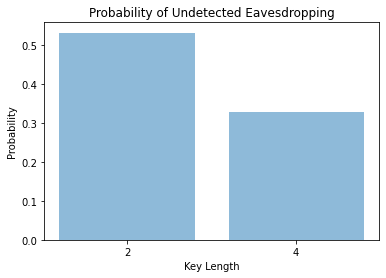

In [22]:
plot_eve_undetected(probs)